# Tracking Eigenvalues: The Shift-Invert Power Method

### 1. The Strategy
When studying how a Hamiltonian $H(\lambda)$ behaves as we vary a parameter $\lambda$, we don't need to re-diagonalize the whole matrix at every step. Instead, we use a **"tracking" strategy**:

* **The Anchor:** We start with a full diagonalization for an initial $\lambda_0$ to get our baseline energy $E(\lambda_0)$.
* **The Follow-up:** As we shift $\lambda$ slightly, we assume the new energy will be close to the previous one. We use the previous energy as a "guess" or "shift", denoted $\tilde{E}(\lambda)$.

---

### 2. Why Shift-Invert?
The goal is to force the Power Method to ignore the edges of the spectrum and focus exactly on the energy level we are tracking. We do this by applying the iteration to the inverse operator:

$$[H - \tilde{E}(\lambda)I]^{-1} |\psi_n\rangle = \eta |\psi_{n+1}\rangle$$

In this setup, the closer the actual energy $E$ is to our guess $\tilde{E}$, the more the term $1/(E - \tilde{E})$ blows up, making that specific state dominant. This allows the algorithm to converge very quickly to the state we are following.



---

### 3. Avoiding Matrix Inversion
In practice, explicitly calculating the inverse matrix $[H - \tilde{E}I]^{-1}$ is **extremely long and computationally expensive**, especially for large systems. 

To get around this, we treat each step as a linear system to solve:
$$(H - \tilde{E}I) |w\rangle = |\psi_n\rangle$$

We use the **MINRES** algorithm to find $|w\rangle$. It's a clever iterative solver that finds the solution without ever needing to actually invert the matrix, saving a massive amount of time and memory.

---

### 4. Getting the Results Back
Once the iteration settles, we have successfully "captured" the state. We can then easily recover the physical properties of the system:

* **The Eigenvector:** The converged $|\psi\rangle$ is the new state of your Hamiltonian.
* **The Eigenvalue:** We find the energy $E$ simply by calculating the **Rayleigh quotient**:

$$E = \frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle}$$

---

# Implementation

In [7]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as dense_linalg
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg
from joblib import Parallel, delayed
from scipy import sparse
from threadpoolctl import threadpool_limits
from tqdm.notebook import tqdm


### Conversion $C^{n} \to R^{2n}$

As minres only works with real matrixes, we need to add some function to convert our complex operators (if they are) to real ones.

In [8]:
def to_real_basis(H_complex):
    if sp.issparse(H_complex):
        return sp.bmat([[H_complex.real, -H_complex.imag], [H_complex.imag, H_complex.real]], format="csr")
    else:
        return np.block([[H_complex.real, -H_complex.imag], [H_complex.imag, H_complex.real]])


def vec_to_real(v_complex):
    return np.concatenate((v_complex.real, v_complex.imag))


def vec_to_complex(v_real):
    n = len(v_real) // 2
    return v_real[:n] + 1j * v_real[n:]


def make_real_operator_from_complex(H_complex_op):
    N = H_complex_op.shape[0]

    def matvec_real_wrapper(v_real_2n):
        v_c = vec_to_complex(v_real_2n)
        res_c = H_complex_op @ v_c
        return vec_to_real(res_c)

    return sp_linalg.LinearOperator((2 * N, 2 * N), matvec=matvec_real_wrapper, dtype=np.float64)

### Shift invert implementation

In [17]:
def shift_invert_step_jax(H_op_sigma, v_prev, shift=1e-4, tol=1e-9, N_power=3, tol_exit=1e-7):
    v_prev = v_prev / np.linalg.norm(v_prev)
    E_current = np.vdot(v_prev,H_op_sigma(0)@v_prev)
    v_current = v_prev
    sigma = E_current + shift

    scale_factor = -1.0 / shift

    for _ in range(N_power):
        iterations.append(0)
        w, exit_code = sp_linalg.minres(
                H_op_sigma(sigma), v_current, x0=v_current * scale_factor, rtol=tol
            )

        norm_w = np.linalg.norm(w)

        v_new = w / norm_w

        E_new = np.vdot(v_new, H_op_sigma(0) @ v_new).real

        v_current = v_new
        E_current = E_new
        sigma = E_current + shift

        residu = np.linalg.norm(H_op_sigma(E_current)@v_current)

        if residu < tol_exit:
            return E_new, v_new


    return E_current, v_current


In [10]:
def get_branch_jax(H_op_wrapper, E_guess, v_prev, param_list, shift=1e-4, tol=1e-9, N_power=3, tol_exit=1e-7):
    n_steps = len(param_list)
    energies = np.zeros(n_steps, dtype=np.float64)
    vectors = []

    v_current = np.concatenate((v_prev.real, v_prev.imag))

    E_current = E_guess
    energies[0] = E_current
    vectors.append(v_prev)

    for i in tqdm(range(1, n_steps)):
        phi_val = param_list[i]
        H_op_sigma = lambda s: H_op_wrapper(phi_val, s)

        E_current, v_current = shift_invert_step_jax(
            H_op_sigma, v_prev = v_current, shift=shift, tol=tol, N_power=N_power, tol_exit=tol_exit
        )

        energies[i] = E_current
        vectors.append(vec_to_complex(v_current))

    return energies, np.array(vectors)

### Sequential

The following functions are useful to get the shift invert results in a sequential approach. But parallelism is more efficient

### Parallelism

As every branch is independant we can try to parallelise the computation, here is the code

### Classical Lanczos implementation

In [11]:
def get_values_Lanczos(H_func, n_states, param_list, tol=1e-8, initial_guess=None):
    global residu_lanczos
    H_0 = H_func(param_list[0])
    if not initial_guess:
        E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_states, which="SA")
        idx = E_initial.argsort()
        E_initial = E_initial[idx]
        V_initial = V_initial[:, idx]
    else:
        E_initial, V_initial = initial_guess

    n_steps = len(param_list)
    all_energies = np.zeros((n_steps, n_states), dtype=np.float64)
    all_vectors = []

    all_energies[0, :] = E_initial
    all_vectors.append(V_initial)

    for i in range(1, n_steps):
        H = H_func(param_list[i])

        v0_guess = np.mean(all_vectors[-1], axis=1)

        H = sp_linalg.LinearOperator(H.shape, matvec=IterationCounter(H))

        energies_i, vectors_i = sp_linalg.eigsh(
            H, k=n_states, v0=v0_guess, which="SA", tol=tol, ncv=max(10, 2 * n_states + 1)
        )

        idx = energies_i.argsort()
        energies_i = energies_i[idx]
        vectors_i = vectors_i[:, idx]

        all_energies[i, :] = energies_i
        all_vectors.append(vectors_i)

        norms = np.linalg.norm(H @ vectors_i - vectors_i * energies_i, axis=0)
        residu_lanczos.append(np.mean(norms))

    return all_energies, np.array(all_vectors)


# Same code as before but without taking the previous vector as a guess for the next one
def get_values_Lanczos_no_guess(H_func, n_states, param_list, tol=1e-8):
    H_0 = H_func(param_list[0])
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_states, which="SA")

    idx = E_initial.argsort()
    E_initial = E_initial[idx]
    V_initial = V_initial[:, idx]

    n_steps = len(param_list)
    all_energies = np.zeros((n_steps, n_states), dtype=np.float64)
    all_vectors = []

    all_energies[0, :] = E_initial
    all_vectors.append(V_initial)

    for i in range(1, n_steps):
        H = H_func(param_list[i])

        H = sp_linalg.LinearOperator(H.shape, matvec=IterationCounter(H))

        energies_i, vectors_i = sp_linalg.eigsh(H, k=n_states, which="SA", tol=tol, ncv=max(100, 2 * n_states + 1))

        idx = energies_i.argsort()
        energies_i = energies_i[idx]
        vectors_i = vectors_i[:, idx]

        all_energies[i, :] = energies_i
        all_vectors.append(vectors_i)

        norms = np.linalg.norm(H @ vectors_i - vectors_i * energies_i, axis=0)
        residu_lanczos.append(np.mean(norms))

    return all_energies, np.array(all_vectors)


class IterationCounter:
    def __init__(self, mat):
        self.mat = mat
        self.count = 0

    def __call__(self, x):
        self.count += 1
        return self.mat @ x


class IterationCounter:
    def __init__(self, mat):
        self.mat = mat
        self.count = 0

    def __call__(self, x):
        self.count += 1
        return self.mat @ x


# Kite application

In [12]:
%load_ext autoreload
%autoreload 2

from common import kite_spectrum_jax_vec as vkite
import jax

jax.config.update("jax_enable_x64", True) 

import jax.numpy as jnp
from functools import partial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We have to define a scipy linealg operator from the kite to give it to our shift invert

In [13]:
@partial(jax.jit, static_argnames=("dims", "n_g", "phiext_val"))
def global_core_matvec(v_jax_2d, phiext_val, sigma, n_g, ops, dims):
    Hv = vkite.apply_qr_hamitonian_to_vec(ops, dims, v_jax_2d, n_g, phiext=phiext_val)
    return Hv - sigma * v_jax_2d



def get_shifted_kite_operator_real(phiext_val, ops, dims, n_g, sigma):
    """
    Build a real-valued SciPy LinearOperator representing (H - sigma * I),
    where H is applied through a JAX-jitted matrix-vector product.

    The operator maps a real vector of size 2N to 2N, corresponding to the
    real and imaginary parts of a complex vector in C^N. This allows the use
    of real-valued Krylov solvers such as MINRES while keeping the Hamiltonian
    application fully in JAX.

    Parameters
    ----------
    phiext_val : float
        External flux parameter entering the Hamiltonian.
    ops : object
        Precomputed operator structures used to apply the Hamiltonian.
    dims : tuple
        Hilbert space dimensions.
    n_g : float
        Offset charge parameter.
    sigma : float
        Spectral shift defining the operator (H - sigma I).
    """

    dims_tuple = tuple(dims)
    complex_dim = np.prod(dims)
    real_dim = 2 * complex_dim

    def matvec_real(v_real_numpy):
        v_complex = v_real_numpy[:complex_dim] + 1j * v_real_numpy[complex_dim:]
        v_jax_2d = jnp.array(v_complex)[:, None]
        
        res_2d = global_core_matvec(v_jax_2d, phiext_val, sigma, n_g, ops, dims_tuple)
        
        res_complex = np.array(res_2d.ravel(), dtype=np.complex128)
        return np.concatenate((res_complex.real, res_complex.imag))

    return sp_linalg.LinearOperator(
        shape=(real_dim, real_dim),
        matvec=matvec_real,
        dtype=np.float64
    )


# Benchmark

Used parameters on the kite 

In [46]:
parameters = vkite.ParamType(
    ECs_GHz=0.072472,
    EL_GHz=1.269,
    ECJ_GHz=4.9895,
    EJ_GHz=17.501,
    eps=0.05702,
    ECc_GHz=0.003989,
    f_r_GHz=4.337,
)


dims = vkite.DEFAULT_DIMS
dims = tuple((np.array(dims) // 1.6).astype(int))
print(f'dimension Hilbert space = {dims}')

ops = vkite.build_static_operators(dims = dims, **parameters)

def my_wrapper(phi, sigma):
    return get_shifted_kite_operator_real(phiext_val=phi, ops=ops, dims=dims, n_g=0.0, sigma=sigma)

dimension Hilbert space = (np.int64(11), np.int64(19), np.int64(19), np.int64(3))


### Benchmark shift value

In [51]:
dim_kept = 8
flux_tabs = np.linspace(np.pi/2, np.pi/2 + np.pi/50, 4)

ref_evals = np.zeros((len(flux_tabs), dim_kept))
ref_evecs = np.zeros((len(flux_tabs), np.prod(dims), dim_kept), dtype=complex)

print("Calcul de référence en cours...")
for i, flux in enumerate(tqdm(flux_tabs)):
    ev, ek, _ = vkite.get_qr_esys_with_jac(
        dims=dims,
        dim_kept=dim_kept,
        n_g=0.0,
        phiext=float(flux),
        **parameters,
        output_jac_params=tuple(),
    )
    ref_evals[i] = ev
    ref_evecs[i] = ek

Calcul de référence en cours...


  0%|          | 0/4 [00:00<?, ?it/s]

Benchmark sur 20 valeurs de shift...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

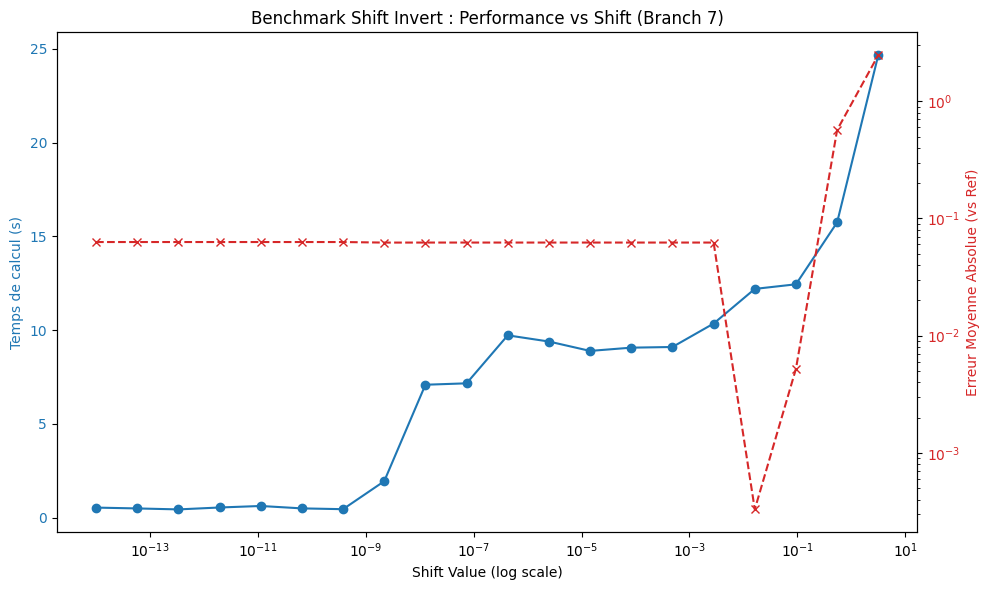

In [71]:
shift_values = np.logspace(-14, 0.5, 20)
times = []
errors = []
dim_kept = 8
flux_tabs = np.linspace(np.pi/2, np.pi/2 + np.pi/50, 4)

target_branch_idx = dim_kept - 1

E_init = ref_evals[0, target_branch_idx]
v_init = ref_evecs[0, :, target_branch_idx]

ref_branch_energies = ref_evals[:, target_branch_idx]

print(f"Benchmark sur {len(shift_values)} valeurs de shift...")

for shift in tqdm(shift_values):
    t0 = time.time()
    
    Es, Vs = get_branch_jax(
        my_wrapper, 
        E_init, 
        v_init,
        flux_tabs, 
        shift=shift,
        tol=1e-9
    )
    
    dt = time.time() - t0
    times.append(dt)
    
    current_error = np.mean(np.abs(np.array(Es) - ref_branch_energies))
    errors.append(current_error)

fig, ax1 = plt.subplots(figsize=(10, 6))

color_time = 'tab:blue'
ax1.set_xlabel('Shift Value (log scale)')
ax1.set_ylabel('Temps de calcul (s)', color=color_time)
ax1.plot(shift_values, times, color=color_time, marker='o', label='Temps')
ax1.tick_params(axis='y', labelcolor=color_time)
ax1.set_xscale('log')

ax2 = ax1.twinx()

color_err = 'tab:red'
ax2.set_ylabel('Erreur Moyenne Absolue (vs Ref)', color=color_err)
ax2.plot(shift_values, errors, color=color_err, marker='x', linestyle='--', label='Erreur')
ax2.tick_params(axis='y', labelcolor=color_err)
ax2.set_yscale('log')

plt.title(f'Benchmark Shift Invert : Performance vs Shift (Branch {target_branch_idx})')
fig.tight_layout()
plt.show()

In [76]:
import jax.numpy as jnp
from jax.numpy.linalg import norm

def compute_precise_residual(vec, energy, flux_val):
    """
    Calcule ||H*v - E*v|| / ||v|| en respectant la signature (N, Batch) de vkite.
    """
    # 1. On force le vecteur en colonne (N, 1) pour satisfaire vec.shape[1]
    # Si vec est (N,), il devient (N, 1). S'il est déjà (N, 1), il ne change pas.
    v_col = jnp.array(vec).reshape(-1, 1)
    
    # 2. On applique l'Hamiltonien
    # La fonction renverra un vecteur de forme (N, 1)
    Hv = vkite.apply_qr_hamitonian_to_vec(
        ops, 
        dims, 
        v_col, 
        n_g=0.0, 
        phiext=float(flux_val)
    )
    
    # 3. Calcul de la différence
    # Hv est (N, 1), v_col est (N, 1), energy est scalaire.
    # Aucun risque de broadcasting foireux ici.
    diff = Hv - energy * v_col
    
    # 4. Norme relative
    return norm(diff) / norm(v_col)

# --- LE DUEL ---

# Paramètres du test
test_flux_idx = 0
flux_val = float(flux_tabs[test_flux_idx])
target_shift = 1e-5  # Ton shift "problématique"
target_npow = 8      # La puissance qui stabilisait la courbe

print(f"--- MOMENT DE VÉRITÉ (Flux = {flux_val:.4f}) ---")

# 1. RÉCUPÉRATION DE LA RÉFÉRENCE
E_ref = ref_evals[test_flux_idx, target_branch_idx]
v_ref = ref_evecs[test_flux_idx, :, target_branch_idx]

res_ref = compute_precise_residual(v_ref, E_ref, flux_val)

print(f"\n[Candidat 1] Référence (Méthode QR)")
print(f"  > Énergie : {E_ref:.8f}")
print(f"  > Résidu  : {res_ref:.2e}")


# 2. CALCUL DU SHIFT-INVERT (L'état "Fantôme")
print(f"\n[Candidat 2] Shift-Invert (Ton code, Shift={target_shift})")
# On relance juste pour ce point pour avoir le vecteur frais
Es_si, Vs_si = get_branch_jax(
    my_wrapper, 
    E_init, 
    v_init, 
    [flux_val], 
    shift=target_shift, 
    tol=1e-9, 
    N_power=target_npow
)
E_si = Es_si[0]
v_si = Vs_si[0]

res_si = compute_precise_residual(v_si, E_si, flux_val)

print(f"  > Énergie : {E_si:.8f}")
print(f"  > Résidu  : {res_si:.2e}")

# 3. VERDICT AUTOMATIQUE
print("\n" + "="*40)
if res_si < res_ref:
    gain = res_ref / res_si
    print(f"✅ VICTOIRE : Ton code a raison ! (Précision x{gain:.1f})")
    print("L'état vers lequel tu converges est physiquement plus juste.")
    print("La référence est une approximation.")
elif res_si > res_ref:
    print("❌ DÉFAITE : Le code converge vers un artefact numérique.")
else:
    print("⚠️ ÉGALITÉ : Les deux méthodes se valent.")
print("="*40)

--- MOMENT DE VÉRITÉ (Flux = 1.5708) ---

[Candidat 1] Référence (Méthode QR)
  > Énergie : -1.20241156
  > Résidu  : 8.19e-14

[Candidat 2] Shift-Invert (Ton code, Shift=1e-05)


0it [00:00, ?it/s]

  > Énergie : -1.20241156
  > Résidu  : 8.19e-14

⚠️ ÉGALITÉ : Les deux méthodes se valent.


Recalcul complet (Énergies + Vecteurs) pour N_power=10...


100%|██████████| 3/3 [00:20<00:00,  6.98s/it]


Calcul de la fidélité...


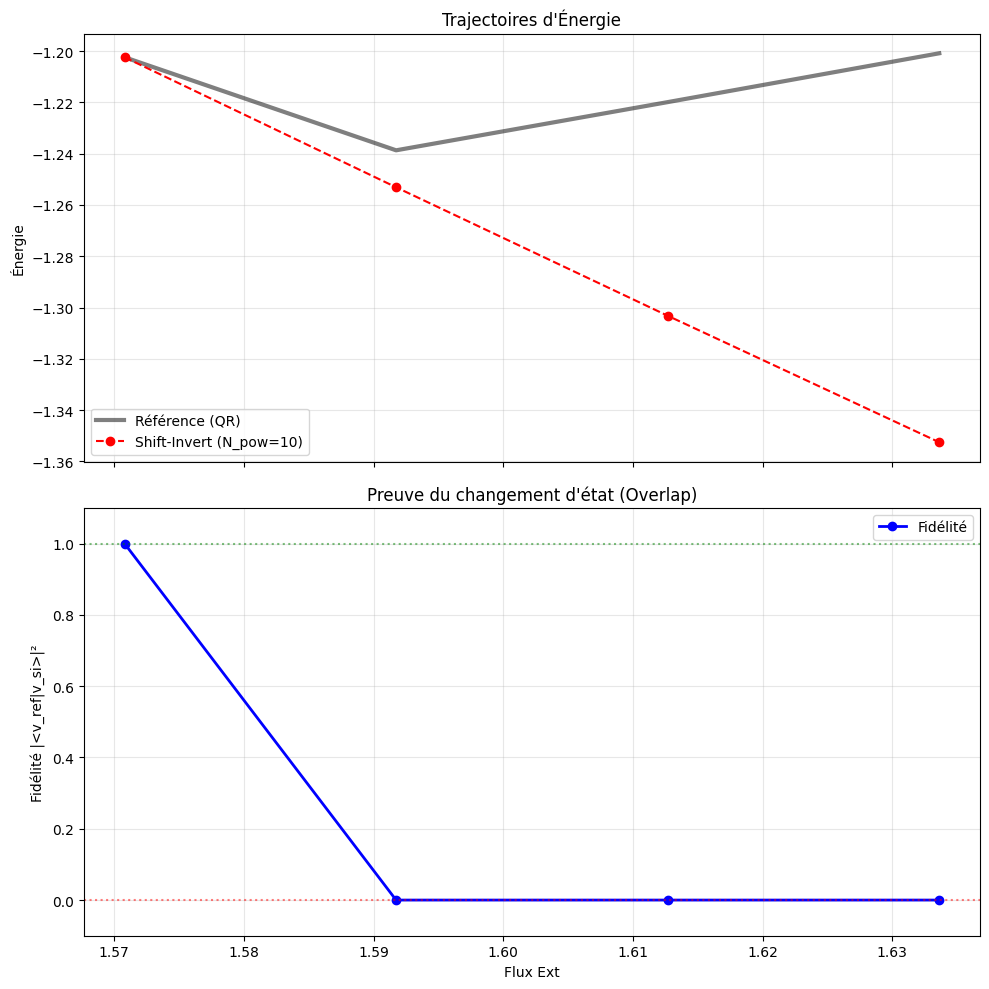

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 1. Paramètres du "Best Case"
target_shift = 1e-5
best_npow = 10 

print(f"Recalcul complet (Énergies + Vecteurs) pour N_power={best_npow}...")

# 2. On lance le calcul en récupérant bien 'Vs' cette fois
Es_final, Vs_final = get_branch_jax(
    my_wrapper, 
    E_init, 
    v_init, 
    flux_tabs, 
    shift=target_shift, 
    tol=1e-14,       # Haute précision
    tol_exit=1e-14, 
    N_power=best_npow
)

# 3. Calcul de la Fidélité (Overlap)
overlaps = []
print("Calcul de la fidélité...")

for i in range(len(flux_tabs)):
    # A. Vecteur Ref (QR - Adiabatique)
    # On aplatit pour être sûr (N,)
    v_ref = ref_evecs[i, :, target_branch_idx].flatten()
    
    # B. Vecteur Shift-Invert (Diabatique ?)
    # Vs_final est une liste, on prend l'élément i et on aplatit
    v_si = np.array(Vs_final[i]).flatten()
    
    # C. Produit scalaire : |<v_ref | v_si>|^2
    # np.vdot gère correctement le conjugué complexe pour les vecteurs complexes
    overlap = np.vdot(v_ref, v_si)
    fidelity = np.abs(overlap)**2
    overlaps.append(fidelity)

# 4. Visualisation du "Divorce"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Graphique du Haut : Énergies
ax1.plot(flux_tabs, ref_branch_energies, 'k-', linewidth=3, alpha=0.5, label='Référence (QR)')
ax1.plot(flux_tabs, Es_final, 'r--o', label=f'Shift-Invert (N_pow={best_npow})')
ax1.set_ylabel('Énergie')
ax1.set_title('Trajectoires d\'Énergie')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique du Bas : Fidélité
ax2.plot(flux_tabs, overlaps, 'b-o', linewidth=2, label='Fidélité')
ax2.set_ylabel('Fidélité |<v_ref|v_si>|²')
ax2.set_xlabel('Flux Ext')
ax2.set_title('Preuve du changement d\'état (Overlap)')
ax2.set_ylim(-0.1, 1.1) # Pour bien voir 0 et 1
ax2.axhline(1.0, color='green', linestyle=':', alpha=0.5)
ax2.axhline(0.0, color='red', linestyle=':', alpha=0.5)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [88]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm

# === 1. PRÉPARATION DES CALCULS ===
# On définit nos deux points de départ (Haut et Bas)
idx_upper = target_branch_idx       # La branche du haut (Celle qu'on suivait avant)
idx_lower = target_branch_idx - 1   # La branche du dessous

# Stockage
traj_upper = {} # Trajectoires partant du haut
traj_lower = {} # Trajectoires partant du bas

# On teste toute la gamme pour voir la transition
shifts_to_test = [1e-14, 1e-10, 1e-5, 1e-2] 

print("🚀 Lancement du 'Dual-Solver' (Haut & Bas)...")

for s in tqdm(shifts_to_test):
    # --- A. Départ du HAUT (Upper) ---
    E_init_up = ref_evals[0, idx_upper]
    v_init_up = ref_evecs[0, :, idx_upper]
    
    # On garde N_power=10 et tol=1e-14 pour être sûr que les sauts sont physiques et pas numériques
    Es_up, _ = get_branch_jax(
        my_wrapper, E_init_up, v_init_up, flux_tabs, 
        shift=s, tol=1e-14, tol_exit=1e-14, N_power=10
    )
    traj_upper[s] = Es_up
    
    # --- B. Départ du BAS (Lower) ---
    E_init_lo = ref_evals[0, idx_lower]
    v_init_lo = ref_evecs[0, :, idx_lower]
    
    Es_lo, _ = get_branch_jax(
        my_wrapper, E_init_lo, v_init_lo, flux_tabs, 
        shift=s, tol=1e-14, tol_exit=1e-14, N_power=10
    )
    traj_lower[s] = Es_lo

# === 2. VISUALISATION (Le "X") ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# --- AX1 : Les Trajectoires ---
# Fond de carte : Références (Gros traits transparents)
ax1.plot(flux_tabs, ref_evals[:, idx_upper], 'k-', linewidth=8, alpha=0.15, label='Ref Haut (Adiabatique)')
ax1.plot(flux_tabs, ref_evals[:, idx_lower], 'g-', linewidth=8, alpha=0.15, label='Ref Bas (Adiabatique)')

colors = cm.viridis(np.linspace(0, 0.95, len(shifts_to_test)))

for i, s in enumerate(shifts_to_test):
    # Astuce : Épaisseur décroissante pour voir les courbes superposées
    lw = 3.5 - 0.8*i      
    ms = 9 - 2*i         
    
    # Trajectoire HAUT (Ronds)
    ax1.plot(flux_tabs, traj_upper[s], marker='o', markersize=ms, linewidth=lw,
             linestyle='-', color=colors[i], label=f'Shift={s:.0e}')
    
    # Trajectoire BAS (Croix)
    ax1.plot(flux_tabs, traj_lower[s], marker='x', markersize=ms, linewidth=lw,
             linestyle=':', color=colors[i]) # Même couleur pour le même shift

ax1.set_title("Test de Croisement : Est-ce que les rails se touchent ?")
ax1.set_ylabel("Énergie")
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# --- AX2 : Analyse de l'Overlap (Distance entre les deux courbes calculées) ---
# Si la distance tombe à 0, c'est qu'ils ont convergé vers le MÊME état (Double comptage !)
for i, s in enumerate(shifts_to_test):
    # Ecart entre la courbe qui part du haut et celle qui part du bas
    delta_E = np.abs(np.array(traj_upper[s]) - np.array(traj_lower[s]))
    
    ax2.plot(flux_tabs, delta_E, marker='d', markersize=6, linewidth=2,
             linestyle='-', color=colors[i], label=f'Shift={s:.0e}')

ax2.axhline(0, color='black', linewidth=1)
ax2.set_yscale('log')
ax2.set_title("Danger de Fusion : Écart d'énergie entre le calcul Haut et le calcul Bas")
ax2.set_ylabel("|E_haut - E_bas| (log)")
ax2.set_xlabel("Flux Ext")
ax2.grid(True, which='both', alpha=0.3)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# === 3. VERDICT TEXTUEL ===
print("\n--- 🕵️‍♂️ DIAGNOSTIC DES COLLISIONS ---")
for s in shifts_to_test:
    # On regarde l'écart final (au dernier point de flux)
    final_gap = np.abs(traj_upper[s][-1] - traj_lower[s][-1])
    
    if final_gap < 1e-6:
        status = "⚠️ COLLISION (OVERLAP)"
        desc = "Les deux calculs ont fini sur le même état. Double comptage !"
    else:
        status = "✅ DISTINCTS"
        desc = f"Les états sont bien séparés (Gap = {final_gap:.1e})"
        
    print(f"Shift {s:.0e} : {status} -> {desc}")

🚀 Lancement du 'Dual-Solver' (Haut & Bas)...


100%|██████████| 4/4 [03:02<00:00, 45.63s/it]



--- 🕵️‍♂️ DIAGNOSTIC DES COLLISIONS ---
Shift 1e-14 : ✅ DISTINCTS -> Les états sont bien séparés (Gap = 1.5e-01)
Shift 1e-10 : ✅ DISTINCTS -> Les états sont bien séparés (Gap = 1.5e-01)
Shift 1e-05 : ✅ DISTINCTS -> Les états sont bien séparés (Gap = 1.5e-01)
Shift 1e-02 : ⚠️ COLLISION (OVERLAP) -> Les deux calculs ont fini sur le même état. Double comptage !


In [87]:
# --- 3. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# === PLOT 1 : LE GRAND "X" ===
# A. Références (Adiabatiques)
ax1.plot(flux_tabs, ref_evals[:, idx_upper], 'k-', linewidth=3, alpha=0.4, label='Ref Haut (Adiabatique)')
ax1.plot(flux_tabs, ref_evals[:, idx_lower], 'g-', linewidth=3, alpha=0.4, label='Ref Bas (Adiabatique)')

# B. Shift-Invert (Upper & Lower starts)
colors = cm.plasma(np.linspace(0, 0.9, len(shifts_to_test)))

for i, s in enumerate(shifts_to_test):
    # Trajectoire partant du HAUT (Ronds)
    ax1.plot(flux_tabs, traj_upper[s], marker='o', markersize=4, 
             linestyle='--', color=colors[i], label=f'Shift={s:.0e} (Start Haut)')
    
    # Trajectoire partant du BAS (Croix) - Même couleur pour le même shift
    ax1.plot(flux_tabs, traj_lower[s], marker='x', markersize=4, 
             linestyle=':', color=colors[i]) # Pas de label pour alléger la légende

ax1.set_title("La collision : Comportement Diabatique (Croix/Ronds) vs Adiabatique (Traits pleins)")
ax1.set_ylabel("Énergie")
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# === PLOT 2 : L'ERREUR "AGNOSTIQUE" ===
# L'idée : On calcule l'écart par rapport à la branche la plus proche (Haut OU Bas)
# Si l'erreur est faible, c'est que le solveur a trouvé UN état valide, peu importe lequel.

for i, s in enumerate(shifts_to_test):
    Es_calc = np.array(traj_upper[s]) # On regarde ceux qui partent du haut
    
    # Calcul des distances aux deux références
    dist_to_upper = np.abs(Es_calc - ref_evals[:, idx_upper])
    dist_to_lower = np.abs(Es_calc - ref_evals[:, idx_lower])
    
    # On prend le MIN des deux erreurs à chaque point
    # "Est-ce que je suis sur un rail valide (que ce soit le vert ou le noir) ?"
    smart_error = np.minimum(dist_to_upper, dist_to_lower)
    
    ax2.plot(flux_tabs, smart_error, marker='o', markersize=4, 
             linestyle='-', color=colors[i], label=f'Shift={s:.0e}')

ax2.set_title("Précision 'Absolue' : Distance à la branche de référence la plus proche")
ax2.set_ylabel("Erreur Min (log)")
ax2.set_xlabel("Flux Ext")
ax2.set_yscale('log')  # Indispensable pour voir la précision 1e-14
ax2.grid(True, which='both', alpha=0.3) # Grid un peu plus fine
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Benchmark n_power and epsilon

Test avec Bad Shift (1e-10)...


  0%|          | 0/3 [00:00<?, ?it/s]

Test avec Good Shift (0.02)...


  0%|          | 0/3 [00:00<?, ?it/s]

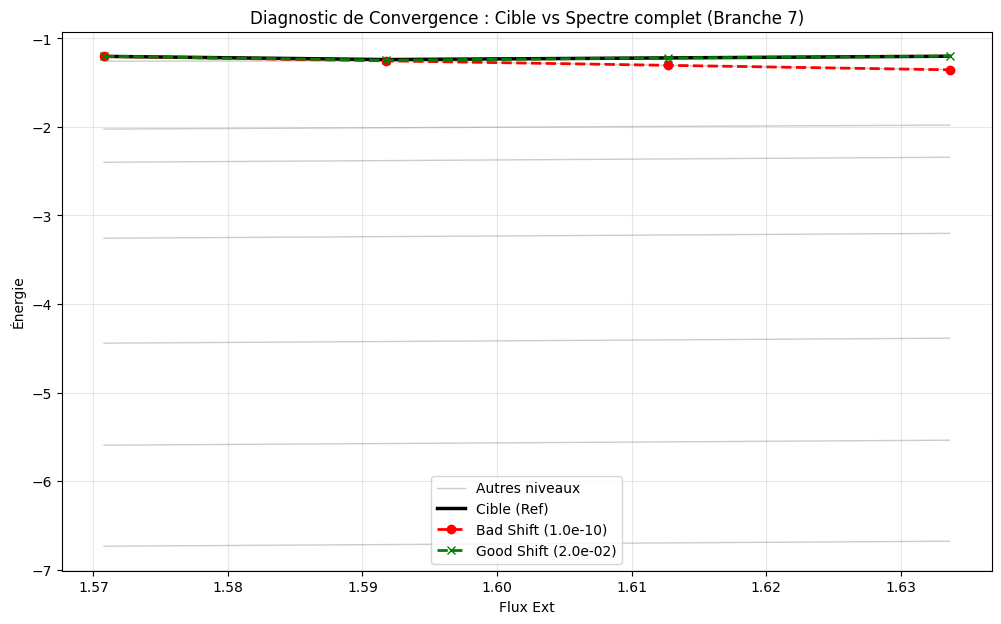

Flux  | Cible Ref    | Bad Shift    | Good Shift   | Fondamental Ref
-----------------------------------------------------------------
0     | -1.202412     | -1.202412     | -1.202412     | -6.736189
1     | -1.238692     | -1.253192     | -1.245472     | -6.717573
2     | -1.219904     | -1.303822     | -1.219909     | -6.698711
3     | -1.200864     | -1.354361     | -1.200864     | -6.679602


In [56]:
import matplotlib.pyplot as plt

# 1. Paramètres de test
bad_shift = 1e-10  # Le shift qui donne l'erreur "plate"
good_shift = 2e-2  # Le shift qui marche bien (creux)

# 2. On relance les calculs
print(f"Test avec Bad Shift ({bad_shift})...")
Es_bad, _ = get_branch_jax(
    my_wrapper, E_init, v_init, flux_tabs, shift=bad_shift, tol=1e-9
)

print(f"Test avec Good Shift ({good_shift})...")
Es_good, _ = get_branch_jax(
    my_wrapper, E_init, v_init, flux_tabs, shift=good_shift, tol=1e-9
)

# 3. Plot
plt.figure(figsize=(12, 7))

# A. Tracer tous les niveaux de référence en gris
# On suppose que ref_evals est de forme (n_flux, dim_kept)
for k in range(dim_kept):
    if k == target_branch_idx:
        label = 'Cible (Ref)'
        color = 'black'
        alpha = 1.0
        linewidth = 2.5
    else:
        label = 'Autres niveaux' if k == 0 else None
        color = 'gray'
        alpha = 0.4
        linewidth = 1.0
    
    plt.plot(flux_tabs, ref_evals[:, k], color=color, alpha=alpha, linewidth=linewidth, linestyle='-', label=label)

# B. Tracer les tentatives Shift-Invert
plt.plot(flux_tabs, Es_bad, 'r--o', linewidth=2, label=f'Bad Shift ({bad_shift:.1e})')
plt.plot(flux_tabs, Es_good, 'g--x', linewidth=2, label=f'Good Shift ({good_shift:.1e})')

plt.title(f"Diagnostic de Convergence : Cible vs Spectre complet (Branche {target_branch_idx})")
plt.xlabel('Flux Ext')
plt.ylabel('Énergie')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Petit tableau récapitulatif pour voir les chiffres exacts
print(f"{'Flux':<5} | {'Cible Ref':<12} | {'Bad Shift':<12} | {'Good Shift':<12} | {'Fondamental Ref':<12}")
print("-" * 65)
for i in range(len(flux_tabs)):
    # On affiche aussi le niveau 0 (fondamental) pour voir si Bad Shift tombe dessus
    ground_state = ref_evals[i, 0]
    print(f"{i:<5} | {ref_branch_energies[i]:.6f}     | {Es_bad[i]:.6f}     | {Es_good[i]:.6f}     | {ground_state:.6f}")

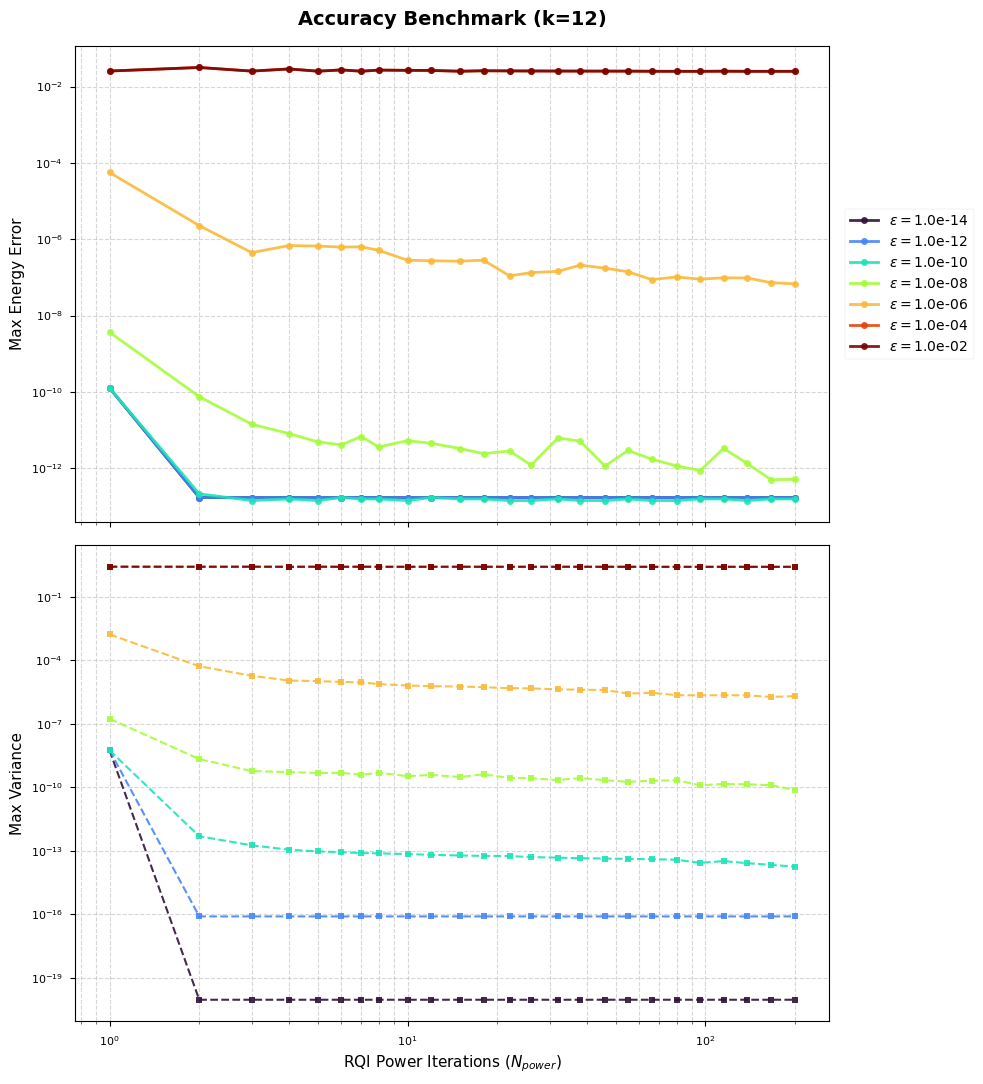

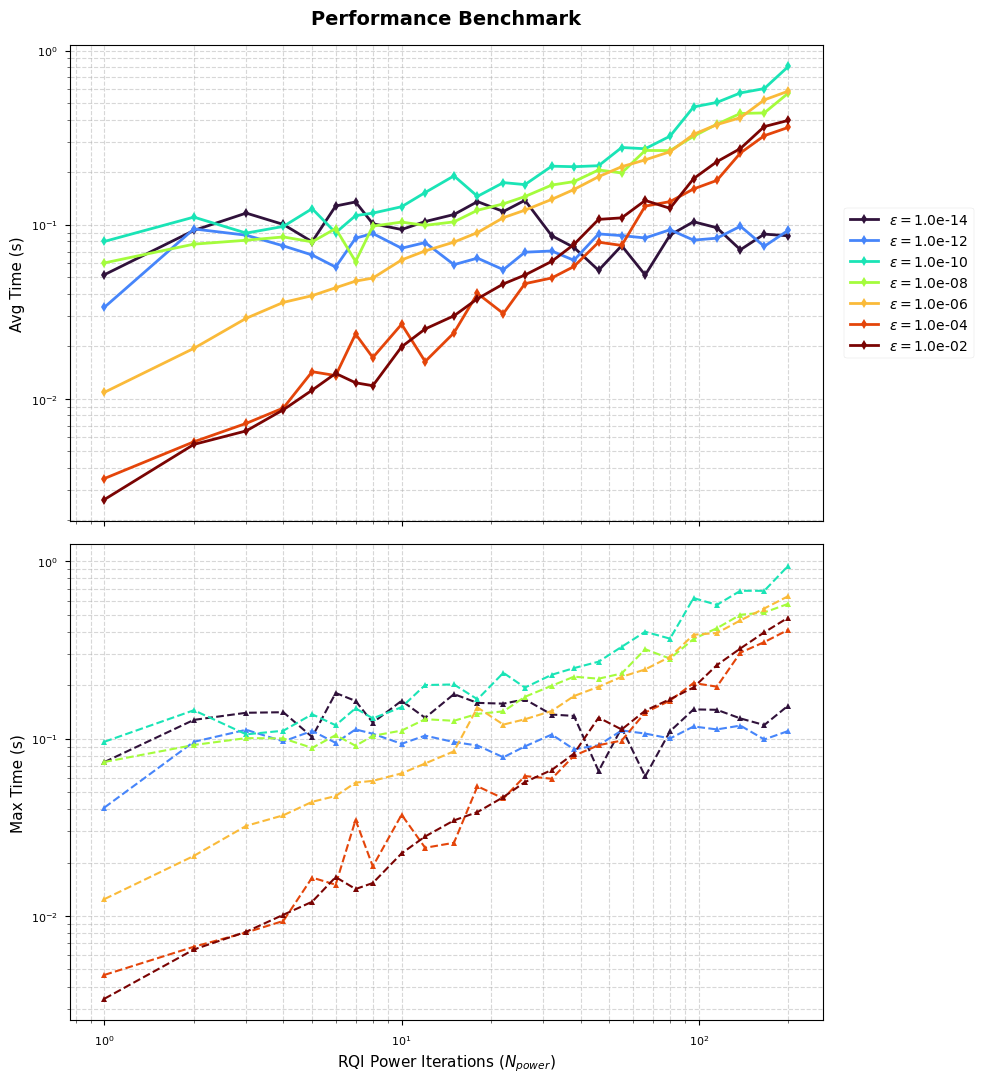

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Sélection rigoureuse de la moitié des données (1 sur 2)
# On prend les clés, on les trie, et on en garde une sur deux
sorted_tols = sorted(results_error.keys())
selected_tols = sorted_tols[::2]

# 2. Nouvelle palette de couleurs dédiée uniquement aux courbes affichées
# Cela garantit d'avoir un vrai bleu au début et un vrai rouge à la fin
colors = plt.cm.turbo(np.linspace(0, 1, len(selected_tols)))

# --- FIGURE 1 : PRECISION ---
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

for tol_val, color in zip(selected_tols, colors):
    lbl = r"$\epsilon = $" + f"{tol_val:.1e}"

    # On ne trace que les données sélectionnées
    ax1.plot(N_power_list, results_error[tol_val], "o-", label=lbl, color=color, markersize=5, linewidth=2, alpha=0.9)

    ax2.plot(
        N_power_list, results_variance[tol_val], "s--", label=lbl, color=color, markersize=5, linewidth=1.5, alpha=0.9
    )

# Esthétique Figure 1
ax1.set_yscale("log")
ax1.set_ylabel(r"Max Energy Error", fontsize=11)
ax1.set_title(f"Accuracy Benchmark (k={target_k})", fontweight="bold", pad=15)
ax1.grid(True, which="both", ls="--", alpha=0.5)
# Légende à droite, centrée verticalement par rapport à l'axe
ax1.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel(r"Max Variance", fontsize=11)
ax2.set_xlabel(r"RQI Power Iterations ($N_{power}$)", fontsize=11)
ax2.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# --- FIGURE 2 : PERFORMANCE ---
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

for tol_val, color in zip(selected_tols, colors):
    lbl = r"$\epsilon = $" + f"{tol_val:.1e}"

    ax3.plot(N_power_list, results_time_avg[tol_val], "d-", label=lbl, color=color, markersize=5, linewidth=2)

    ax4.plot(N_power_list, results_time_max[tol_val], "^--", color=color, markersize=5, linewidth=1.5)

# Esthétique Figure 2
ax3.set_yscale("log")
ax3.set_ylabel("Avg Time (s)", fontsize=11)
ax3.set_title("Performance Benchmark", fontweight="bold", pad=15)
ax3.grid(True, which="both", ls="--", alpha=0.5)
ax3.legend(bbox_to_anchor=(1.02, 0.5), loc="center left")

ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylabel("Max Time (s)", fontsize=11)
ax4.set_xlabel(r"RQI Power Iterations ($N_{power}$)", fontsize=11)
ax4.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Benchmark tol_exit

Tracking de la branche 12 (N_power=20)
Pré-calcul des références exactes...


Benchmarking tol_exit:   0%|          | 0/196 [00:00<?, ?it/s]

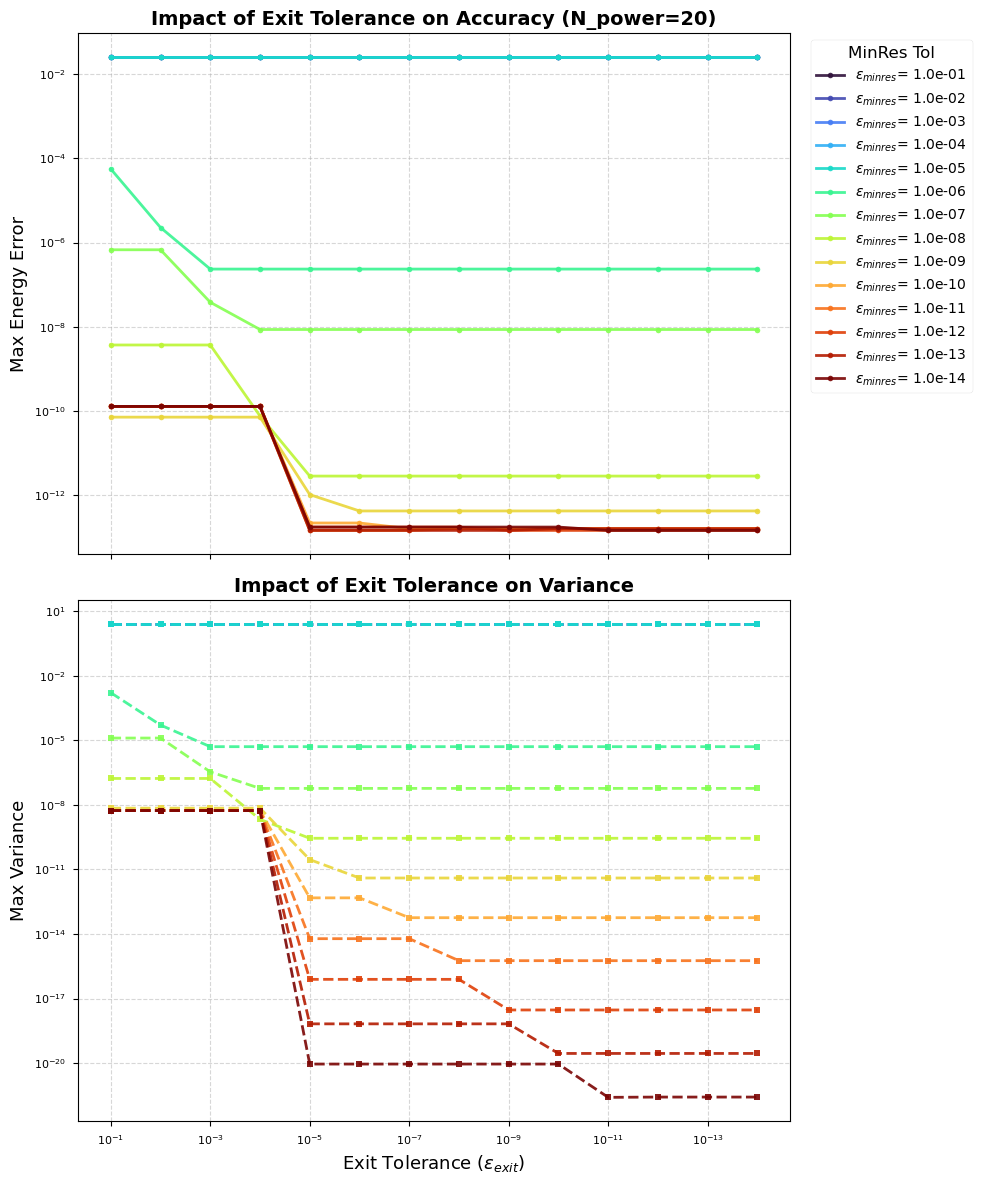

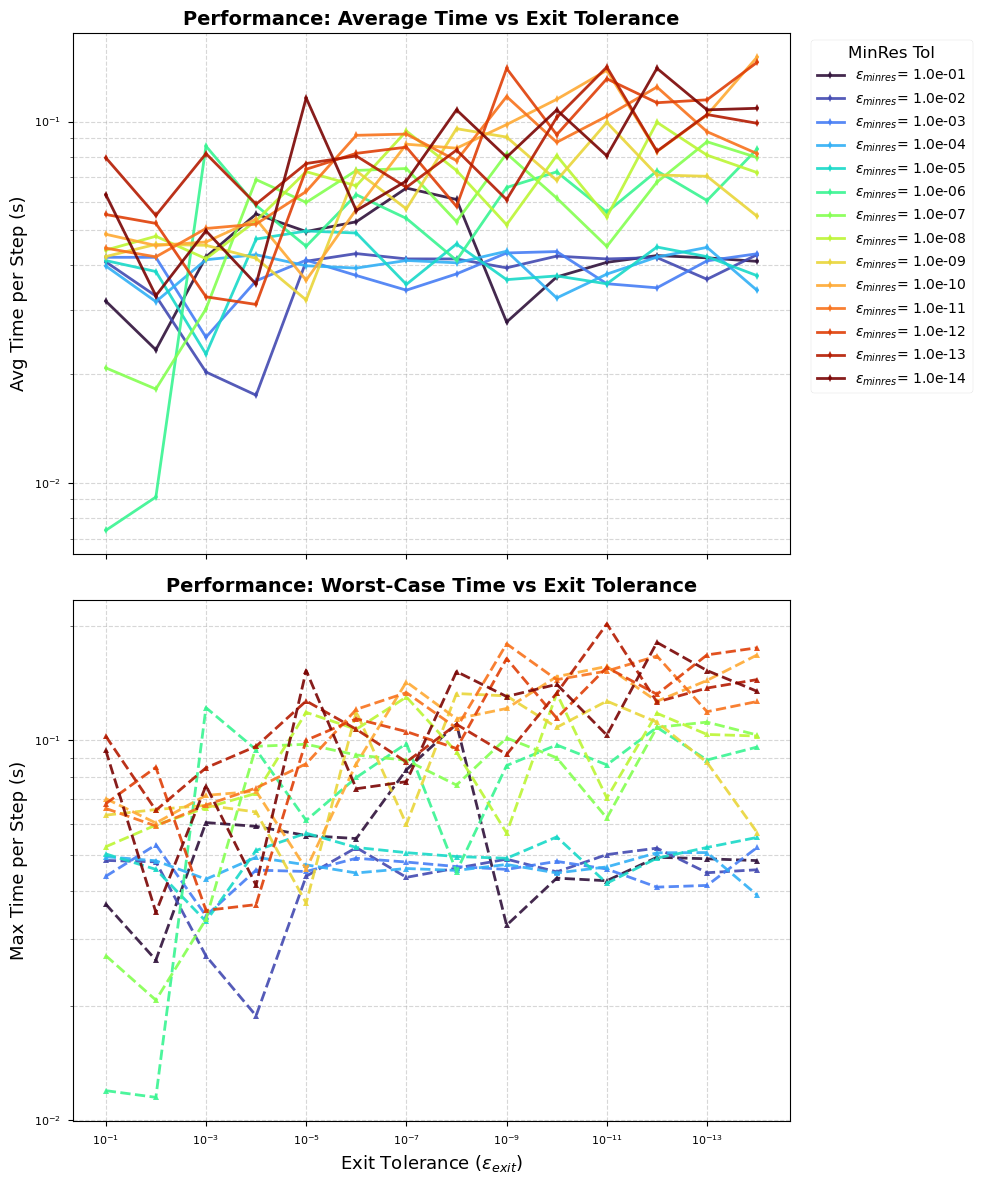

In [ ]:
# --- PARAMETRES ---
coupling_vals = np.linspace(1.0, 1.02, 5)
target_k = 12
fixed_shift = 1e-5
N_power_fixed = 20  # Fixé comme demandé

# --- PRE-CALCUL REFERENCE (Inchangé) ---
# Je suppose que ops_data et les Hamiltoniens sont déjà en mémoire ou recréés ici
# Pour la cohérence du script, je réutilise les blocs précédents si nécessaire
# (Je saute la création explicite des opérateurs pour aller droit au benchmark)

print(f"Tracking de la branche {target_k} (N_power={N_power_fixed})")

# Si besoin de recalculer les références (décommenter si c'est un nouveau run)
exact_energies = []
Hs_list = []
initial_v = None

print("Pré-calcul des références exactes...")
for i, c in enumerate(coupling_vals):
    H = H_var_coupling_mat(c)
    Hs_list.append(H)

    if sp.issparse(H):
        H_dense = H.toarray()
    else:
        H_dense = H
    H_dense = (H_dense + H_dense.T) / 2

    evals, evecs = dense_linalg.eigh(H_dense)
    exact_energies.append(evals[target_k])
    if i == 0:
        initial_v = evecs[:, target_k]

# --- PARAMETRES BENCHMARK ---
# AXE X : tol_exit (Critère d'arrêt de la boucle RQI)
# Variation de 1e-1 à 1e-14
tol_exit_list = np.logspace(-1, -14, 14)

# COULEURS : tol (Tolérance du solveur minres)
# On garde la même liste pour comparer les courbes
tol_minres_list = np.logspace(-1, -14, 14)

# Dictionnaires de résultats
results_error = {}
results_variance = {}
results_time_avg = {}
results_time_max = {}

total_iterations = len(tol_minres_list) * len(tol_exit_list)
pbar = tqdm(total=total_iterations, desc="Benchmarking tol_exit")

# --- BOUCLE PRINCIPALE ---
for tol_val in tol_minres_list:  # Boucle sur les couleurs (MinRes precision)
    max_errors_list = []
    max_variances_list = []
    avg_times_list = []
    max_times_list = []

    for exit_val in tol_exit_list:  # Boucle sur l'axe X (Exit criterion)
        v_current = initial_v.copy()
        current_max_error = 0.0
        current_max_variance = 0.0
        step_times = []

        for i in range(1, len(coupling_vals)):
            # Reset globales
            global iterations, residu_shift, time_min_res
            iterations = []
            residu_shift = []
            time_min_res = 0

            H_target = Hs_list[i]
            E_ref = exact_energies[i]

            # --- MESURE ---
            t_start = time.perf_counter()
            E_calc, v_calc = shift_invert_step(
                H_target,
                0,
                v_current,
                shift=fixed_shift,
                tol=tol_val,  # Précision du solveur (interne)
                N_power=N_power_fixed,  # Fixé à 6
                tol_exit=exit_val,  # Condition de sortie (externe)
            )
            t_end = time.perf_counter()
            step_times.append(t_end - t_start)
            # -------------

            # Erreur
            err = np.abs(E_calc - E_ref)
            if err > current_max_error:
                current_max_error = err

            # Variance
            res_vec = H_target @ v_calc - E_calc * v_calc
            variance = (np.linalg.norm(res_vec)) ** 2
            if variance > current_max_variance:
                current_max_variance = variance

            v_current = v_calc

        # Stockage
        max_errors_list.append(current_max_error)
        max_variances_list.append(current_max_variance)
        if step_times:
            avg_times_list.append(np.mean(step_times))
            max_times_list.append(np.max(step_times))
        else:
            avg_times_list.append(0)
            max_times_list.append(0)

        pbar.update(1)

    # Enregistrement
    results_error[tol_val] = max_errors_list
    results_variance[tol_val] = max_variances_list
    results_time_avg[tol_val] = avg_times_list
    results_time_max[tol_val] = max_times_list

pbar.close()

# --- PLOTTING ---
# On inverse l'axe X pour avoir la tolérance la plus stricte (1e-14) à droite ou à gauche selon préférence
# Standard : 1e-14 à gauche, 1e-1 à droite.

colors = plt.cm.turbo(np.linspace(0, 1, len(tol_minres_list)))

# FIGURE 1 : PRECISION
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Erreur
for (tol_val, errors), color in zip(results_error.items(), colors):
    ax1.plot(
        tol_exit_list,
        errors,
        "o-",
        label=r"$\epsilon_{minres}$" + f"= {tol_val:.1e}",
        color=color,
        markersize=4,
        alpha=0.9,
    )

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel(r"Max Energy Error")
ax1.set_title(f"Impact of Exit Tolerance on Accuracy (N_power={N_power_fixed})", fontweight="bold")
ax1.grid(True, which="both")
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="MinRes Tol")
# Optionnel : Inverser l'axe X pour avoir "plus strict" vers la droite
ax1.invert_xaxis()

# Variance
for (tol_val, variances), color in zip(results_variance.items(), colors):
    ax2.plot(
        tol_exit_list,
        variances,
        "s--",
        label=r"$\epsilon_{minres}$" + f"= {tol_val:.1e}",
        color=color,
        markersize=4,
        alpha=0.9,
    )

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel(r"Exit Tolerance ($\epsilon_{exit}$)")
ax2.set_ylabel(r"Max Variance")
ax2.set_title(f"Impact of Exit Tolerance on Variance", fontweight="bold")
ax2.grid(True, which="both")
# ax2.invert_xaxis() # Si on veut inverser ici aussi (automatique via sharex normalement)

plt.tight_layout()
plt.show()

# FIGURE 2 : PERFORMANCE
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Temps Moyen
for (tol_val, times), color in zip(results_time_avg.items(), colors):
    ax3.plot(
        tol_exit_list,
        times,
        "d-",
        label=r"$\epsilon_{minres}$" + f"= {tol_val:.1e}",
        color=color,
        markersize=4,
        alpha=0.9,
    )

ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylabel("Avg Time per Step (s)")
ax3.set_title(f"Performance: Average Time vs Exit Tolerance", fontweight="bold")
ax3.grid(True, which="both")
ax3.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="MinRes Tol")
ax3.invert_xaxis()

# Temps Max
for (tol_val, times), color in zip(results_time_max.items(), colors):
    ax4.plot(
        tol_exit_list,
        times,
        "^--",
        label=r"$\epsilon_{minres}$" + f"= {tol_val:.1e}",
        color=color,
        markersize=4,
        alpha=0.9,
    )

ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_xlabel(r"Exit Tolerance ($\epsilon_{exit}$)")
ax4.set_ylabel("Max Time per Step (s)")
ax4.set_title(f"Performance: Worst-Case Time vs Exit Tolerance", fontweight="bold")
ax4.grid(True, which="both")

plt.tight_layout()
plt.show()

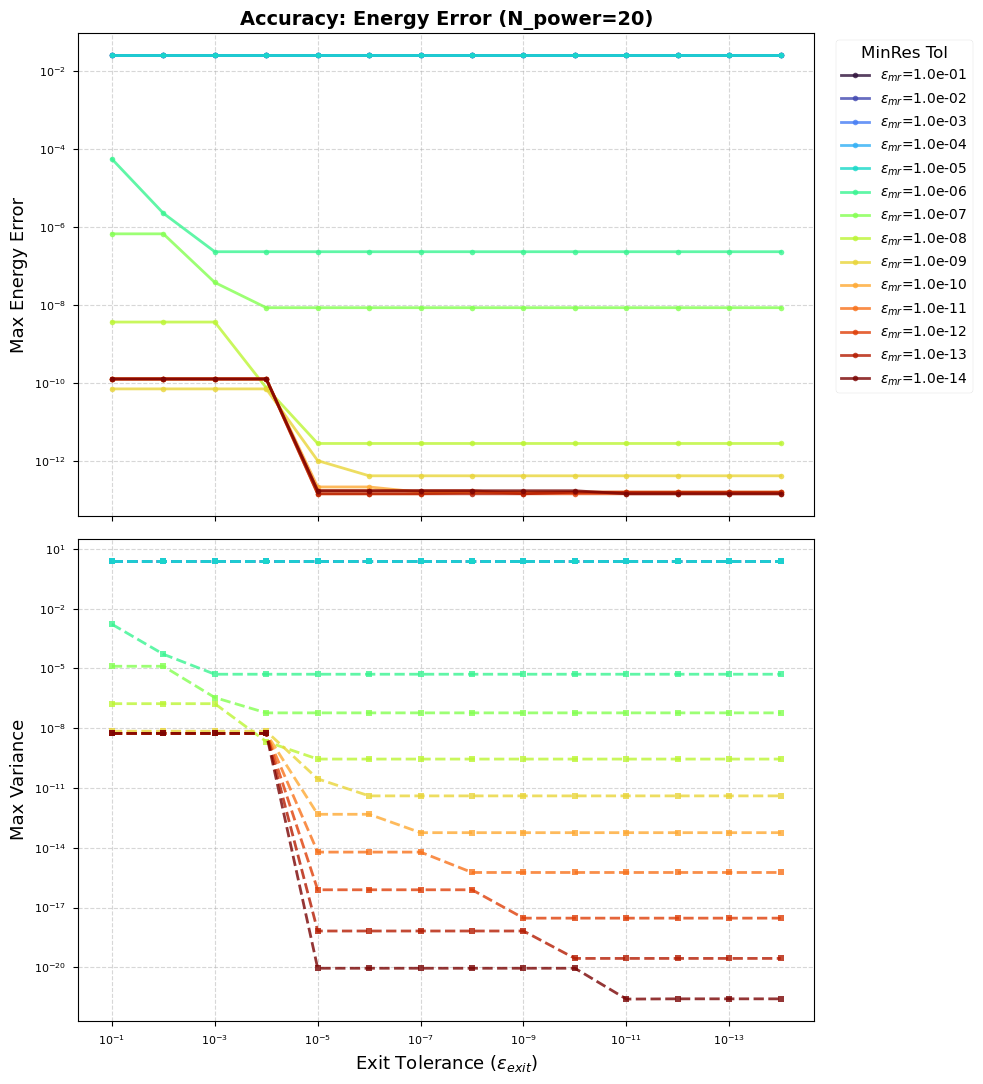

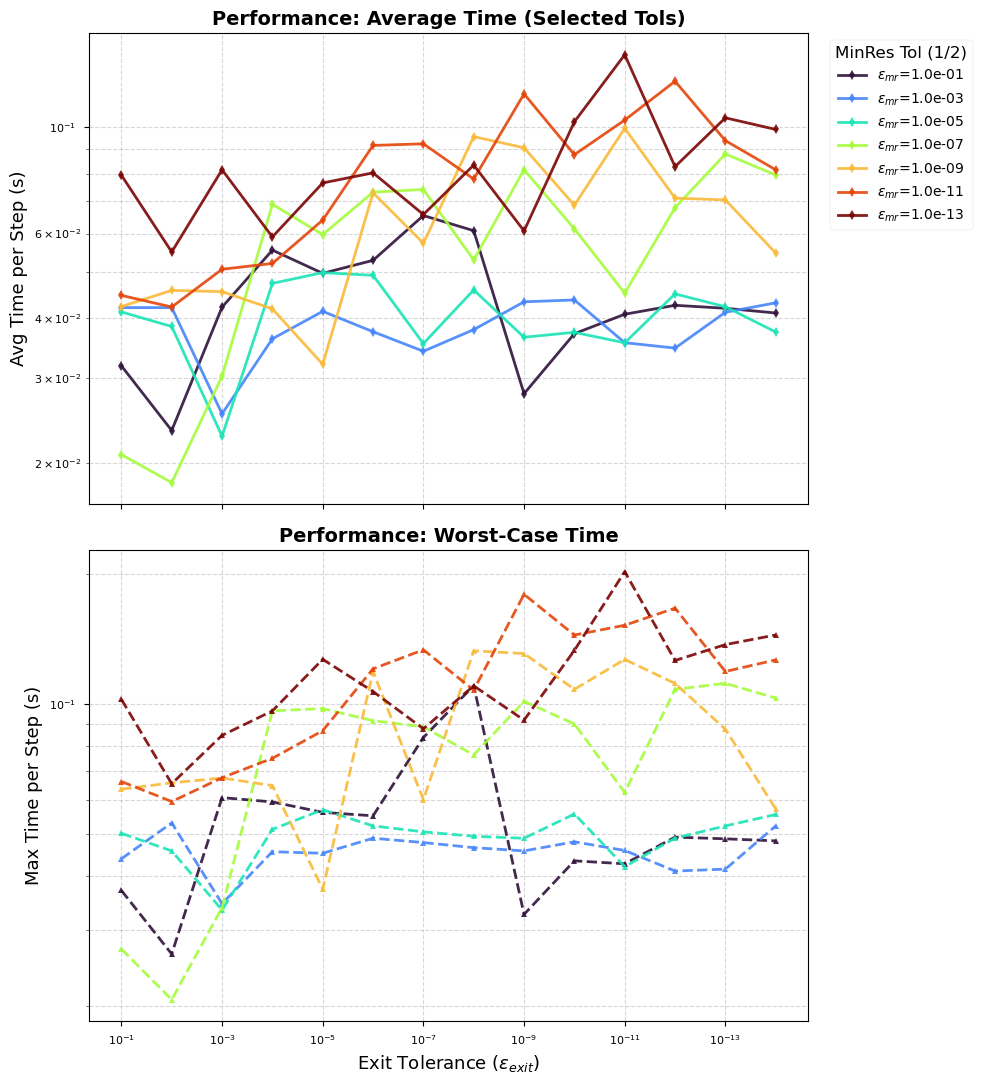

In [ ]:
# --- PLOTTING ---
# On prépare deux listes de couleurs : une complète, une réduite
colors_full = plt.cm.turbo(np.linspace(0, 1, len(tol_minres_list)))

# Pour la performance, on filtre : une tolérance sur deux
selected_tols_perf = list(results_time_avg.keys())[::2]
colors_perf = plt.cm.turbo(np.linspace(0, 1, len(selected_tols_perf)))

# FIGURE 1 : PRECISION (Toutes les courbes)
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

for (tol_val, errors), color in zip(results_error.items(), colors_full):
    ax1.plot(
        tol_exit_list, errors, "o-", label=r"$\epsilon_{mr}$" + f"={tol_val:.1e}", color=color, markersize=4, alpha=0.8
    )

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel(r"Max Energy Error")
ax1.set_title(f"Accuracy: Energy Error (N_power={N_power_fixed})", fontweight="bold")
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="MinRes Tol", fontsize="small")
ax1.invert_xaxis()

for (tol_val, variances), color in zip(results_variance.items(), colors_full):
    ax2.plot(tol_exit_list, variances, "s--", color=color, markersize=4, alpha=0.8)

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel(r"Exit Tolerance ($\epsilon_{exit}$)")
ax2.set_ylabel(r"Max Variance")
ax2.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# FIGURE 2 : PERFORMANCE (Une courbe sur deux pour éviter l'effet "barre")
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

# On boucle uniquement sur les tolérances sélectionnées pour la performance
for tol_val, color in zip(selected_tols_perf, colors_perf):
    # Plot Temps Moyen (Plot 3)
    ax3.plot(
        tol_exit_list,
        results_time_avg[tol_val],
        "d-",
        label=r"$\epsilon_{mr}$" + f"={tol_val:.1e}",
        color=color,
        markersize=5,
        alpha=0.9,
    )

    # Plot Temps Max (Plot 4)
    ax4.plot(tol_exit_list, results_time_max[tol_val], "^--", color=color, markersize=5, alpha=0.9)

ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylabel("Avg Time per Step (s)")
ax3.set_title(f"Performance: Average Time (Selected Tols)", fontweight="bold")
ax3.grid(True, which="both", ls="--", alpha=0.5)
ax3.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="MinRes Tol (1/2)")
ax3.invert_xaxis()

ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_xlabel(r"Exit Tolerance ($\epsilon_{exit}$)")
ax4.set_ylabel("Max Time per Step (s)")
ax4.set_title(f"Performance: Worst-Case Time", fontweight="bold")
ax4.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Benchmark Lanczos vs Shift invert parallel vs Shift invert sequential

In [ ]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 60
tol_val = 1e-7

coupling_list = np.linspace(1.0, 1.01, 6, dtype=np.float64)
n_states_list = [10, 20, 50, 75]

ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=1000, osc_cut=60)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

Hs_list = [H_var_coupling_mat(c) for c in coupling_list]

print(f"Calcul de la référence Exact Diag sur {len(coupling_list)} pas...")

exact_energies_ref, exact_vectors_ref = get_values_exact_diagonalization(
    H_var_coupling_mat, max(n_states_list), coupling_list
)

print("Référence calculée et stockée.")

Calcul de la référence Exact Diag sur 6 pas...


Exact Diag: 100%|██████████| 6/6 [00:58<00:00,  9.68s/it]

Référence calculée et stockée.


In [ ]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 60

# --- ALGORITHM PARAMETERS ---
si_params = {"shift": 1e-5, "tol": 1e-10, "tol_exit": 1e-7, "N_power": 5}

n_states_list = [10]
coupling_list = np.linspace(1.0, 1.005, 5, dtype=np.float64)

# --- OPERATOR CONSTRUCTION ---
try:
    ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=1000, osc_cut=60)
    H_func = lambda E_coupling: get_transmon_readout_matrix_explicit(
        ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
    )
    dim_H = H_func(coupling_list[0]).shape[0]
except NameError:
    raise RuntimeError("Physics functions (build_naked_operators...) are not defined.")

# --- REFERENCE CALCULATION (Initial Conditions) ---
print("Calculating Initial Conditions (Exact Diag)...")
max_states = max(n_states_list)
ref_E, ref_V = get_values_exact_diagonalization(H_func, max_states, coupling_list)
E0_all = ref_E[:, 0]
V0_all = ref_V[:, 0, :].T

# Results storage
results = {
    "parallel": {"time": [], "var": [], "overlap": []},
    "sequential": {"time": [], "var": [], "overlap": []},
    "lanczos": {"time": [], "var": [], "overlap": []},
}

# =============================================================================
# 3. BENCHMARK LOOP
# =============================================================================
for n_st in n_states_list:
    print(f"\nTesting n_states = {n_st} ...")

    current_E0 = E0_all[:n_st]
    current_V0 = V0_all[:, :n_st]

    # --- A. PARALLEL SHIFT-INVERT ---
    start = time.perf_counter()
    with threadpool_limits(limits=1, user_api="blas"):
        res_par = Parallel(n_jobs=-1)(
            delayed(get_branch_real)(H_func, current_E0[k], current_V0[:, k], coupling_list, **si_params)
            for k in range(n_st)
        )
    t_par = time.perf_counter() - start

    # Reconstruct arrays for metric calculation
    # res_par[k][0] -> energies (steps,), res_par[k][1] -> vectors (steps, dim)
    E_par = np.stack([res_par[k][0] for k in range(n_st)], axis=1)  # Shape: (Steps, n_st)
    V_par = np.stack([res_par[k][1] for k in range(n_st)], axis=1)  # Shape: (Steps, n_st, dim)

    var_par, over_par = compute_metrics(H_func, coupling_list, E_par, V_par)

    results["parallel"]["time"].append(t_par)
    results["parallel"]["var"].append(var_par)
    results["parallel"]["overlap"].append(over_par)
    print(f"  [Parallel] Time: {t_par:.4f}s | Var: {var_par:.1e} | Overlap: {over_par:.1e}")

    # --- B. SEQUENTIAL SHIFT-INVERT ---
    start = time.perf_counter()
    # Expects return: E_seq (n_st, steps), V_seq (n_st, steps, dim)
    E_seq, V_seq = get_values_shift_invert_real(H_func, n_st, coupling_list, **si_params)
    t_seq = time.perf_counter() - start

    # Transpose for metrics (Steps, n_st, ...)
    E_seq_T = E_seq.T
    V_seq_T = np.transpose(V_seq, (1, 0, 2))

    var_seq, over_seq = compute_metrics(H_func, coupling_list, E_seq_T, V_seq_T)

    results["sequential"]["time"].append(t_seq)
    results["sequential"]["var"].append(var_seq)
    results["sequential"]["overlap"].append(over_seq)
    print(f"  [Sequential] Time: {t_seq:.4f}s | Var: {var_seq:.1e}")

    # --- C. LANCZOS ---
    start = time.perf_counter()
    # Expects return: E_lan (steps, n_st), V_lan (steps, n_st, dim)
    E_lan, V_lan = get_values_Lanczos(H_func, n_st, coupling_list, tol=si_params["tol"])
    t_lan = time.perf_counter() - start

    # Handle Lanczos potential transpose issues
    if E_lan.shape[0] != len(coupling_list):
        E_lan = E_lan.T
        V_lan = np.transpose(V_lan, (1, 0, 2))

    var_lan, over_lan = compute_metrics(H_func, coupling_list, E_lan, V_lan)

    results["lanczos"]["time"].append(t_lan)
    results["lanczos"]["var"].append(var_lan)
    results["lanczos"]["overlap"].append(over_lan)
    print(f"  [Lanczos] Time: {t_lan:.4f}s | Var: {var_lan:.1e}")

# =============================================================================
# 4. PLOTS (ENGLISH)
# =============================================================================
plt.style.use("seaborn-v0_8-paper")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12), sharex=True, dpi=120)

# --- PLOT 1: TIME ---
ax1.plot(n_states_list, results["sequential"]["time"], "o--", label="SI Sequential", color="#457B9D")
ax1.plot(n_states_list, results["lanczos"]["time"], "s-", label="Lanczos", color="#E63946")
ax1.plot(n_states_list, results["parallel"]["time"], "D-", label="SI Parallel", color="#1D3557", linewidth=2)
ax1.set_ylabel("Time (s)", fontweight="bold")
ax1.set_title("1. Performance", fontweight="bold")
ax1.grid(True, linestyle=":", alpha=0.6)
ax1.legend()

# --- PLOT 2: VARIANCE (Physical Validity) ---
ax2.plot(n_states_list, results["sequential"]["var"], "o--", color="#457B9D")
ax2.plot(n_states_list, results["lanczos"]["var"], "s-", color="#E63946")
ax2.plot(n_states_list, results["parallel"]["var"], "D-", color="#1D3557")
ax2.set_ylabel(r"Max Variance $||(H-E)v||$", fontweight="bold")
ax2.set_title("2. Physical Validity (Variance)", fontweight="bold")
ax2.set_yscale("log")
ax2.axhline(y=1e-6, color="gray", linestyle=":", label="Acceptable Threshold")
ax2.grid(True, linestyle=":", alpha=0.6)
ax2.legend()

# --- PLOT 3: OVERLAP (Uniqueness/Orthogonality) ---
ax3.plot(n_states_list, results["sequential"]["overlap"], "o--", label="SI Sequential", color="#457B9D")
ax3.plot(n_states_list, results["lanczos"]["overlap"], "s-", label="Lanczos", color="#E63946")
ax3.plot(n_states_list, results["parallel"]["overlap"], "D-", label="SI Parallel", color="#1D3557")
ax3.set_ylabel(r"Max Overlap $|\langle \psi_i | \psi_j \rangle|_{i \neq j}$", fontweight="bold")
ax3.set_xlabel("Number of States", fontweight="bold")
ax3.set_title("3. Uniqueness of Solutions (Orthogonality)", fontweight="bold")
ax3.set_yscale("log")
ax3.axhline(y=1e-2, color="gray", linestyle=":", label="Critical Threshold")
ax3.grid(True, linestyle=":", alpha=0.6)
ax3.legend()

plt.tight_layout()
plt.show()

Calculating Initial Conditions (Exact Diag)...


Exact Diag: 100%|██████████| 5/5 [00:42<00:00,  8.51s/it]



Testing n_states = 10 ...
  [Parallel] Time: 8.8135s | Var: 1.3e-06 | Overlap: 2.5e-06


100%|██████████| 4/4 [00:13<00:00,  3.33s/it]


  [Sequential] Time: 15.0208s | Var: 1.3e-06
  [Lanczos] Time: 4.6770s | Var: 1.5e-08


In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# --- 1. PRÉPARATION DES DONNÉES ---
n_total_plotted = E_par.shape[1]
n_steps = E_par.shape[0]

print(f"Visualisation Contrastée : {n_total_plotted} branches.")

E_si_plot = E_par.T

if ref_E.shape[0] >= n_total_plotted:
    E_ref_plot = ref_E[:n_total_plotted, :]
else:
    E_ref_plot = ref_E.T[:n_total_plotted, :]

# --- 2. PLOT AVEC COULEURS CYCLIQUES ---
fig, ax = plt.subplots(figsize=(14, 10), dpi=100)

# STRATÉGIE DE COULEUR : MODULO
# On prend une liste de couleurs très distinctes et on boucle dessus.
# Ainsi, la courbe k et la courbe k+1 auront toujours des couleurs radicalement différentes.
distinct_colors = [
    "#e6194b",
    "#3cb44b",
    "#ffe119",
    "#4363d8",
    "#f58231",
    "#911eb4",
    "#46f0f0",
    "#f032e6",
    "#bcf60c",
    "#fabebe",
    "#008080",
    "#e6beff",
    "#9a6324",
    "#fffac8",
    "#800000",
    "#aaffc3",
    "#808000",
    "#ffd8b1",
    "#000075",
    "#808080",
    "#ffffff",
    "#000000",
]
# Ou plus simplement la palette standard Matplotlib 'tab10' qui est très bien
cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # Liste de 10 couleurs distinctes

# On génère la liste des couleurs pour chaque état k
colors = [cycle_colors[k % len(cycle_colors)] for k in range(n_total_plotted)]

print("Génération du graphique avec contraste élevé entre voisins...")

for k in range(n_total_plotted):
    c = colors[k]

    # --- A. Lanczos (Ligne continue) ---
    lbl_ref = "Lanczos (Ref)" if k == 0 else None
    # Ligne un peu plus épaisse pour bien voir la couleur
    ax.plot(coupling_list, E_ref_plot[k, :], linestyle="-", linewidth=1.2, color=c, alpha=0.6, label=lbl_ref)

    # --- B. Shift-Invert (Croix) ---
    lbl_si = "Shift-Invert" if k == 0 else None
    # Croix noires ou de la même couleur ?
    # De la même couleur c'est mieux pour associer visuellement,
    # mais on peut les faire un peu plus foncées ou saturées si besoin.
    ax.plot(
        coupling_list,
        E_si_plot[k, :],
        linestyle="None",
        marker="x",
        markersize=8,
        markeredgewidth=2,
        color=c,
        label=lbl_si,
    )

# --- 3. MISE EN PAGE ---
ax.set_title(
    f"Spectre Complet (Couleurs Cycliques)\nZoomer pour inspecter les croisements", fontweight="bold", fontsize=14
)
ax.set_xlabel("Paramètre de Couplage ($E_{coupling}$)", fontsize=12)
ax.set_ylabel("Énergie ($E_J$)", fontsize=12)

# Légende simplifiée
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="black", lw=2, label="Lanczos (Ligne)"),
    Line2D([0], [0], marker="x", color="black", lw=0, label="Shift-Invert (Croix)"),
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=12)

ax.grid(True, which="both", linestyle=":", linewidth=0.5, color="gray", alpha=0.5)

plt.show()

Visualisation Contrastée : 50 branches.
Génération du graphique avec contraste élevé entre voisins...


### Benchmark Lanczos vs Shit invert parallel

In [ ]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5

# Tes paramètres optimisés
si_params = {"shift": 1e-4, "tol": 5e-10, "tol_exit": 1e-7, "N_power": 3}
coupling_list = np.linspace(1.0, 1.005, 5, dtype=np.float64)

# BENCHMARK CONFIGURATION
transmon_sizes = [30, 50, 70, 100, 150]
osc_sizes = [30, 50, 70, 100, 150]
n_states_list = [5, 10, 12, 15]

# Stockage en mémoire
data_si = {ns: {"size": [], "time": [], "var": [], "over": []} for ns in n_states_list}
data_la = {ns: {"size": [], "time": [], "var": [], "over": []} for ns in n_states_list}

FILENAME = "benchmark_data_save.pkl"

# =============================================================================
# 3. BENCHMARK LOOP
# =============================================================================
for tr_size, osc_size in zip(transmon_sizes, osc_sizes):
    print(f"\n--- Matrix Construction (Transmon={tr_size}, Osc={osc_size}) ---")
    try:
        ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, tr_size, n_cut=1000, osc_cut=osc_size)
        H_func = lambda E_coupling: get_transmon_readout_matrix_explicit(
            ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
        )
        matrix_dim = H_func(coupling_list[0]).shape[0]
        print(f"Matrix Dimension: {matrix_dim} x {matrix_dim}")
    except NameError:
        raise RuntimeError("Physics functions not defined.")

    # --- CORRECTION 1 : Définir max_st_needed AVANT ---
    max_st_needed = max(n_states_list)

    if max_st_needed > matrix_dim:
        print("Skipping: Matrix too small for requested states.")
        continue

    # --- CORRECTION 2 : Initial Guess via Sparse Solver (eigsh) ---
    print("Computing Reference (Initial Guess for t=0) with Sparse Solver...")

    H_0 = H_func(coupling_list[0])

    # Utilisation de eigsh au lieu de exact_diagonalization (dense)
    E0_all, V0_all = sp_linalg.eigsh(H_0, k=max_st_needed, which="SA", tol=1e-12)
    # E0_all est (k,)
    # V0_all est (Dim, k) -> Format parfait pour la suite

    for n_st in n_states_list:
        if n_st > matrix_dim:
            continue

        print(f"   Testing n_states = {n_st} ...")
        current_E0 = E0_all[:n_st]
        current_V0 = V0_all[:, :n_st]  # Slicing (Dim, n_st)

        # --- PARALLEL SHIFT-INVERT ---
        start = time.perf_counter()
        with threadpool_limits(limits=1, user_api="blas"):
            res_par = Parallel(n_jobs=-1)(
                delayed(get_branch_real)(H_func, current_E0[k], current_V0[:, k], coupling_list, **si_params)
                for k in range(n_st)
            )
        t_par = time.perf_counter() - start

        E_par = np.stack([res_par[k][0] for k in range(n_st)], axis=1)
        V_par = np.stack([res_par[k][1] for k in range(n_st)], axis=1)

        var_par, over_par = compute_metrics(H_func, coupling_list, E_par, V_par)

        data_si[n_st]["size"].append(matrix_dim)
        data_si[n_st]["time"].append(t_par)
        data_si[n_st]["var"].append(var_par)
        data_si[n_st]["over"].append(over_par)

        # --- LANCZOS ---
        start = time.perf_counter()

        # Passage du guess (E, V) à Lanczos
        initial_guess_lanczos = (current_E0, current_V0)

        E_lan, V_lan = get_values_Lanczos(H_func, n_st, coupling_list, tol=1e-7, initial_guess=initial_guess_lanczos)
        t_lan = time.perf_counter() - start

        if E_lan.shape[0] != len(coupling_list):
            E_lan = E_lan.T
            V_lan = np.transpose(V_lan, (1, 0, 2))

        var_lan, over_lan = compute_metrics(H_func, coupling_list, E_lan, V_lan)

        data_la[n_st]["size"].append(matrix_dim)
        data_la[n_st]["time"].append(t_lan)
        data_la[n_st]["var"].append(var_lan)
        data_la[n_st]["over"].append(over_lan)

        # --- SAUVEGARDE IMMEDIATE ---
        with open(FILENAME, "wb") as f:
            pickle.dump({"si": data_si, "la": data_la, "params": si_params}, f)

print("\nCalcul terminé. Données sauvegardées.")

# =============================================================================
# 4. PLOTTING
# =============================================================================
plt.style.use("seaborn-v0_8-paper")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 14), sharex=True, dpi=120)

colors = plt.cm.turbo(np.linspace(0, 1, len(n_states_list)))

for idx, n_st in enumerate(n_states_list):
    c = colors[idx]
    sizes = data_si[n_st]["size"]
    if not sizes:
        continue

    # Shift-Invert: Dashed + Squares
    ax1.plot(sizes, data_si[n_st]["time"], marker="s", linestyle="--", color=c)
    ax2.plot(sizes, data_si[n_st]["var"], marker="s", linestyle="--", color=c)
    ax3.plot(sizes, data_si[n_st]["over"], marker="s", linestyle="--", color=c)

    # Lanczos: Solid + Crosses
    ax1.plot(sizes, data_la[n_st]["time"], marker="x", linestyle="-", color=c, alpha=0.8)
    ax2.plot(sizes, data_la[n_st]["var"], marker="x", linestyle="-", color=c, alpha=0.8)
    ax3.plot(sizes, data_la[n_st]["over"], marker="x", linestyle="-", color=c, alpha=0.8)

# --- CUSTOM LEGENDS ---
h_si = ax1.plot([], [], color="black", linestyle="--", marker="s", label="Shift-Invert (Par)")[0]
h_la = ax1.plot([], [], color="black", linestyle="-", marker="x", label="Lanczos")[0]

leg_method = ax1.legend(
    handles=[h_si, h_la], title="Used Method", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True
)
ax1.add_artist(leg_method)

handles_states = []
for idx, n_st in enumerate(n_states_list):
    h = ax1.plot([], [], color=colors[idx], marker="o", linestyle="", label=f"N={n_st}")[0]
    handles_states.append(h)

ax1.legend(handles=handles_states, title="$n_{state}$", bbox_to_anchor=(1.02, 0.75), loc="upper left", frameon=True)

# --- LAYOUT ---
ax1.set_title("Benchmarking Shift-Invert vs Lanczos\nMatrix Size Scaling", fontweight="bold")
ax1.set_ylabel("Computation Time (s)", fontweight="bold")
ax1.grid(True, linestyle=":", alpha=0.6)

ax2.set_ylabel(r"Max Variance $||(H-E)v||^2$", fontweight="bold")
ax2.set_yscale("log")
ax2.grid(True, linestyle=":", alpha=0.6)

ax3.set_ylabel(r"Max Overlap (Orthogonality)", fontweight="bold")
ax3.set_xlabel("Matrix Dimension (Hilbert Space Size)", fontweight="bold")
ax3.set_yscale("log")
ax3.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


--- Matrix Construction (Transmon=30, Osc=30) ---
Matrix Dimension: 900 x 900
Computing Reference (Initial Guess for t=0) with Sparse Solver...
   Testing n_states = 5 ...
   Testing n_states = 10 ...

--- Matrix Construction (Transmon=50, Osc=50) ---
Matrix Dimension: 2500 x 2500
Computing Reference (Initial Guess for t=0) with Sparse Solver...
   Testing n_states = 5 ...
   Testing n_states = 10 ...

--- Matrix Construction (Transmon=70, Osc=70) ---
Matrix Dimension: 4900 x 4900
Computing Reference (Initial Guess for t=0) with Sparse Solver...
   Testing n_states = 5 ...
   Testing n_states = 10 ...

--- Matrix Construction (Transmon=100, Osc=100) ---
Matrix Dimension: 10000 x 10000
Computing Reference (Initial Guess for t=0) with Sparse Solver...
   Testing n_states = 5 ...
   Testing n_states = 10 ...

--- Matrix Construction (Transmon=150, Osc=150) ---
Matrix Dimension: 22500 x 22500
Computing Reference (Initial Guess for t=0) with Sparse Solver...
   Testing n_states = 5 ...
   

In [ ]:
%matplotlib qt
plt.style.use("seaborn-v0_8-paper")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 14), sharex=True, dpi=120)

colors = plt.cm.turbo(np.linspace(0, 1, len(n_states_list)))

for idx, n_st in enumerate(n_states_list):
    c = colors[idx]
    sizes = data_si[n_st]["size"]
    if not sizes:
        continue

    # Shift-Invert: Dashed + Squares
    ax1.plot(sizes, data_si[n_st]["time"], marker="s", linestyle="--", color=c)
    ax2.plot(sizes, data_si[n_st]["var"], marker="s", linestyle="--", color=c)
    ax3.plot(sizes, data_si[n_st]["over"], marker="s", linestyle="--", color=c)

    # Lanczos: Solid + Crosses
    ax1.plot(sizes, data_la[n_st]["time"], marker="x", linestyle="-", color=c, alpha=0.8)
    ax2.plot(sizes, data_la[n_st]["var"], marker="x", linestyle="-", color=c, alpha=0.8)
    ax3.plot(sizes, data_la[n_st]["over"], marker="x", linestyle="-", color=c, alpha=0.8)

# --- CUSTOM LEGENDS ---
h_si = ax1.plot([], [], color="black", linestyle="--", marker="s", label="Shift-Invert (Par)")[0]
h_la = ax1.plot([], [], color="black", linestyle="-", marker="x", label="Lanczos")[0]

leg_method = ax1.legend(
    handles=[h_si, h_la], title="Used Method", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True
)
ax1.add_artist(leg_method)

handles_states = []
for idx, n_st in enumerate(n_states_list):
    h = ax1.plot([], [], color=colors[idx], marker="o", linestyle="", label=f"N={n_st}")[0]
    handles_states.append(h)

ax1.legend(handles=handles_states, title="$n_{state}$", bbox_to_anchor=(1.02, 0.75), loc="upper left", frameon=True)

# --- LAYOUT ---
ax1.set_title("Benchmarking Shift-Invert vs Lanczos\nMatrix Size Scaling", fontweight="bold")
ax1.set_ylabel("Computation Time (s)", fontweight="bold")
ax1.grid(True, linestyle=":", alpha=0.6)

ax2.set_ylabel(r"Max Variance $||(H-E)v||^2$", fontweight="bold")
ax2.set_yscale("log")
ax2.grid(True, linestyle=":", alpha=0.6)

ax3.set_ylabel(r"Max Overlap (Orthogonality)", fontweight="bold")
ax3.set_xlabel("Matrix Dimension (Hilbert Space Size)", fontweight="bold")
ax3.set_yscale("log")
ax3.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### Benchmark Lanczos only

In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
import numpy as np

# Si la commande magique ci-dessus ne marche pas (selon ton IDE),
# tu peux essayer : plt.switch_backend('Qt5Agg') ou juste ignorer si tu as déjà une fenêtre interactive.

# --- 1. SÉLECTION DES DONNÉES ---
# On reprend tes données calculées (n_total = 100 supposé)
n_total = E_par.shape[1]
n_zoom = 10
indices_to_plot = range(n_total - n_zoom, n_total)  # Les 10 derniers

print(f"Plot RAW (sans offset) des états k={min(indices_to_plot)} à {max(indices_to_plot)}")

# --- 2. PLOT INTERACTIF ---
fig, ax = plt.subplots(figsize=(12, 8))

# Couleurs distinctes pour suivre chaque état
colors = plt.cm.jet(np.linspace(0, 1, len(indices_to_plot)))

for i, k in enumerate(indices_to_plot):
    c = colors[i]

    # Données brutes
    # Lanczos (Ref)
    if ref_E.shape[0] == n_total:
        y_ref = ref_E[k, :]
    else:
        y_ref = ref_E[:, k]

    # Shift-Invert (Calculé)
    y_si = E_par[:, k]

    # TRACÉ BRUT
    # 1. Lanczos : Ligne continue fine
    ax.plot(coupling_list, y_ref, linestyle="-", linewidth=1.0, color=c, alpha=0.6)

    # 2. Shift-Invert : Croix (sans ligne)
    # Regarde si les croix restent bien sur leur ligne de couleur
    ax.plot(
        coupling_list, y_si, linestyle="None", marker="x", markersize=8, markeredgewidth=1.5, color=c, label=f"k={k}"
    )

ax.set_title(
    f"Énergies Brutes (États {min(indices_to_plot)}-{max(indices_to_plot)})\nZoom manuel requis pour voir les sauts",
    fontweight="bold",
)
ax.set_xlabel("Couplage")
ax.set_ylabel("Énergie ($E_J$)")

# Légende simplifiée
# On affiche les états pour pouvoir identifier qui est qui
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="État k", fontsize="small")

ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Plot RAW (sans offset) des états k=90 à 99


In [ ]:
plt.style.use("seaborn-v0_8-paper")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 14), sharex=True)

# PLOT 1 : TEMPS
ax1.plot(n_states_list, results["t_l"], "s-", label="Lanczos", color="#E63946", markersize=6)
ax1.plot(n_states_list, results["t_si"], "o--", label="Shift-Invert", color="#1D3557", markersize=6)
ax1.set_ylabel("Total Time (s)", fontweight="bold")
ax1.set_title("Time vs Number of States", fontsize=12)
ax1.legend()
ax1.grid(True, ls=":")

# PLOT 2 : ERREUR D'ÉNERGIE (Log scale)
ax2.plot(n_states_list, results["err_l"], "s-", color="#E63946")
ax2.plot(n_states_list, results["err_si"], "o--", color="#1D3557")
ax2.set_yscale("log")
ax2.set_ylabel(r"Max Energy Error $\Delta E$", fontweight="bold")
ax2.set_title("Absolute Accuracy", fontsize=12)
ax2.grid(True, which="both", ls=":")

# PLOT 3 : VARIANCE (Log scale)
ax3.plot(n_states_list, results["var_l"], "s-", color="#E63946")
ax3.plot(n_states_list, results["var_si"], "o--", color="#1D3557")
ax3.set_yscale("log")
ax3.set_ylabel(r"Max Variance $\sigma^2$", fontweight="bold")
ax3.set_xlabel("Number of Target States ($n_{st}$)", fontsize=11)
ax3.set_title("Intrinsic Quality (Residual Norm)", fontsize=12)
ax3.grid(True, which="both", ls=":")

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PRÉPARATION DES DONNÉES ---

# On s'assure que E_lan est dans le bon sens (n_steps, n_states)
if E_lan.shape[0] != len(coupling_list):
    E_lan = E_lan.T

# Dimensions actuelles
n_steps, n_computed = E_lan.shape

# On sélectionne les 10 derniers indices calculés
n_zoom = 10
start_idx = max(0, n_computed - n_zoom)
indices_zoom = np.arange(start_idx, n_computed)

print(f"Visualisation des états k={indices_zoom[0]} à {indices_zoom[-1]} sur {n_steps} points de couplage.")

# --- 2. TRACÉ ---
plt.style.use("seaborn-v0_8-paper")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, dpi=120)

# --- PLOT 1 : ÉVOLUTION DES ÉNERGIES (SPECTRE) ---
# On boucle sur chaque état k sélectionné
for i, k in enumerate(indices_zoom):
    # Récupération des trajectoires
    traj_exact = exact_energies_arr[:, k]
    traj_lan = E_lan[:, k]

    # Gestion de la légende (on ne l'affiche qu'une fois pour ne pas polluer)
    label_exact = "Exact Diag" if i == 0 else "_nolegend_"
    label_lan = "Lanczos" if i == 0 else "_nolegend_"

    # Tracé Exact (Ligne continue noire/grise)
    ax1.plot(coupling_list, traj_exact, color="black", alpha=0.5, linewidth=2, label=label_exact)

    # Tracé Lanczos (Pointillés rouges ou croix)
    ax1.plot(
        coupling_list,
        traj_lan,
        color="#E63946",
        linestyle="--",
        marker="x",
        markersize=6,
        linewidth=1.5,
        label=label_lan,
    )

ax1.set_ylabel("Energy")
ax1.set_title(
    f"Top {n_zoom} Energy Levels Evolution (States k={indices_zoom[0]}-{indices_zoom[-1]})", fontweight="bold"
)
ax1.legend(loc="upper left")
ax1.grid(True, linestyle=":", alpha=0.6)

# --- PLOT 2 : ÉVOLUTION DE L'ERREUR ---
# On trace l'erreur pour chaque branche
for i, k in enumerate(indices_zoom):
    traj_exact = exact_energies_arr[:, k]
    traj_lan = E_lan[:, k]
    error = np.abs(traj_lan - traj_exact)

    ax2.plot(coupling_list, error, "o-", markersize=4, alpha=0.8, label=f"k={k}")

# Ligne de tolérance
ax2.axhline(y=tol_val, color="gray", linestyle="--", linewidth=1.5, label=f"Tol ({tol_val})")

ax2.set_xlabel("Coupling Parameter")
ax2.set_ylabel(r"Absolute Error $|E_{lan} - E_{exact}|$")
ax2.set_yscale("log")
ax2.set_title("Stability Check: Error per Branch vs Coupling", fontweight="bold")

# Légende compacte à droite pour identifier quelle branche pose problème
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="State Index", fontsize="small")
ax2.grid(True, which="both", linestyle=":", alpha=0.6)

plt.tight_layout()
plt.show()

NameError: name 'E_lan' is not defined

### On complex hamiltonians

In [ ]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 25
osc_cut = 50
residu_shift = []
residu_lanczos = []

ops_data_complex = build_naked_operators(EJ_val, EC_T_val, n_transmon_keep, n_cut=300, osc_cut=osc_cut)

H_var_coupling = lambda E_coupling: get_transmon_readout_hamiltonian(  # noqa: E731
    ops_data_complex, EC_R_val, EL_R_val, E_coupling=E_coupling
)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data_complex, EC_R_val, EL_R_val, E_coupling=E_coupling
)


coupling_list = np.linspace(1.0, 1.01, 5, dtype=np.float64)

start_si_opt_c = time.perf_counter()
energies_si_opt_c, vectors_si_opt_c = get_values_shift_invert_complex_parallel(
    H_var_coupling_mat,
    n_states=3,
    param_list=coupling_list,
)
end_si_opt_c = time.perf_counter()

start_mat_c = time.perf_counter()
energies_mat_c, vectors_mat_c = get_values_Lanczos(H_var_coupling_mat, n_states=3, param_list=coupling_list)
end_mat_c = time.perf_counter()

print(f"Lanczos matriciel a pris {end_mat_c - start_mat_c} secondes")
print(f"Shift invert a pris {end_si_opt_c - start_si_opt_c} secondes")


c:\Users\eliot\anaconda3\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


Lanczos matriciel a pris 1.2997092000150587 secondes
Shift invert a pris 1.800195599993458 secondes


Calcul des diagnostics...


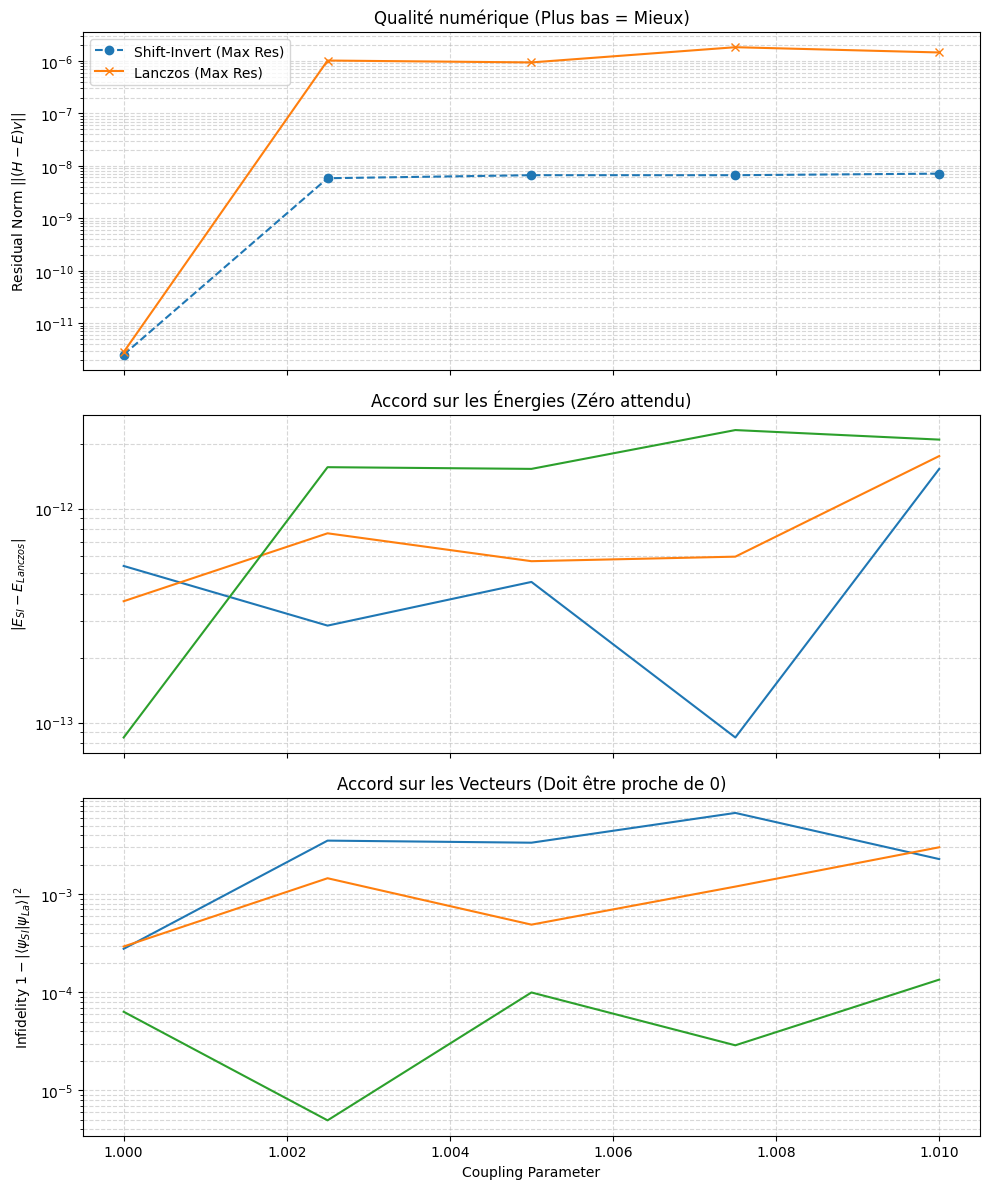

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# FONCTION DE DIAGNOSTIC
# =============================================================================
def compute_diagnostics(H_func, param_list, E_list, V_list, label):
    """Calcule les résidus pour une méthode donnée."""
    residuals = []
    
    n_steps = len(param_list)
    
    for t in range(n_steps):
        H = H_func(param_list[t])
        E_t = E_list[t] # (N_states,)
        
        # --- CORRECTION ICI ---
        # 1. Cas Shift-Invert (souvent une liste de matrices)
        if isinstance(V_list, list):
            V_t = V_list[t]
        # 2. Cas Lanczos (souvent un gros np.array de dimension (Steps, Dim, States))
        elif isinstance(V_list, np.ndarray):
            V_t = V_list[t]
        else:
            raise ValueError(f"Format non supporté: {type(V_list)}")

        # Calcul du résidu : || H*v - E*v ||
        # H @ V_t fait (Dim, N_states)
        # V_t * E_t fait (Dim, N_states) grâce au broadcasting
        diff = H @ V_t - V_t * E_t
        
        # Norme par état (axis=0 si les états sont en colonnes)
        norms = np.linalg.norm(diff, axis=0)
        residuals.append(norms)
        
    return np.array(residuals)

# =============================================================================
# CALCULS
# =============================================================================
print("Calcul des diagnostics...")

# 1. Résidus intrinsèques (Est-ce que c'est un vecteur propre ?)
resids_si = compute_diagnostics(H_var_coupling_mat, coupling_list, energies_si_opt_c, vectors_si_opt_c, "Shift-Invert")
resids_la = compute_diagnostics(H_var_coupling_mat, coupling_list, energies_mat_c, vectors_mat_c, "Lanczos")

# 2. Différence entre les deux méthodes (Consistance)
# Différence d'énergie absolue
delta_E = np.abs(energies_si_opt_c - energies_mat_c)

# Fidélité (Overlap) : |<v_si | v_la>|^2
fidelities = []
n_steps = len(coupling_list)
n_states = energies_si_opt_c.shape[1]

for t in range(n_steps):
    # Produit scalaire hermitien : V_si_dagger @ V_la
    # On ne regarde que la diagonale (état k vs état k)
    v_si = vectors_si_opt_c[t]
    v_la = vectors_mat_c[t]
    
    # Attention aux dimensions, on suppose (Dim, N_states)
    overlaps = np.abs(np.sum(v_si.conj() * v_la, axis=0))**2 
    fidelities.append(overlaps)

fidelities = np.array(fidelities)

# =============================================================================
# PLOTTING
# =============================================================================
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Graph 1 : Résidus (Qualité intrinsèque)
# On plot la moyenne des résidus sur les états calculés ou le pire cas
axes[0].plot(coupling_list, np.max(resids_si, axis=1), 'o--', label='Shift-Invert (Max Res)', color='tab:blue')
axes[0].plot(coupling_list, np.max(resids_la, axis=1), 'x-', label='Lanczos (Max Res)', color='tab:orange')
axes[0].set_ylabel(r"Residual Norm $||(H-E)v||$")
axes[0].set_yscale('log')
axes[0].set_title("Qualité numérique (Plus bas = Mieux)")
axes[0].legend()
axes[0].grid(True, which="both", ls="--", alpha=0.5)

# Graph 2 : Différence d'énergie (SI vs Lanczos)
for k in range(n_states):
    axes[1].plot(coupling_list, delta_E[:, k], label=f'State {k}')
axes[1].set_ylabel(r"$|E_{SI} - E_{Lanczos}|$")
axes[1].set_yscale('log')
axes[1].set_title("Accord sur les Énergies (Zéro attendu)")
axes[1].grid(True, which="both", ls="--", alpha=0.5)

# Graph 3 : Fidélité des vecteurs (SI vs Lanczos)
for k in range(n_states):
    # On plot 1 - Fidélité pour voir l'erreur en log scale
    axes[2].plot(coupling_list, 1 - fidelities[:, k], label=f'State {k}')
axes[2].set_ylabel(r"Infidelity $1 - |\langle \psi_{SI} | \psi_{La} \rangle|^2$")
axes[2].set_yscale('log')
axes[2].set_title("Accord sur les Vecteurs (Doit être proche de 0)")
axes[2].set_xlabel("Coupling Parameter")
axes[2].grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Lanczos and shift invert energy plots

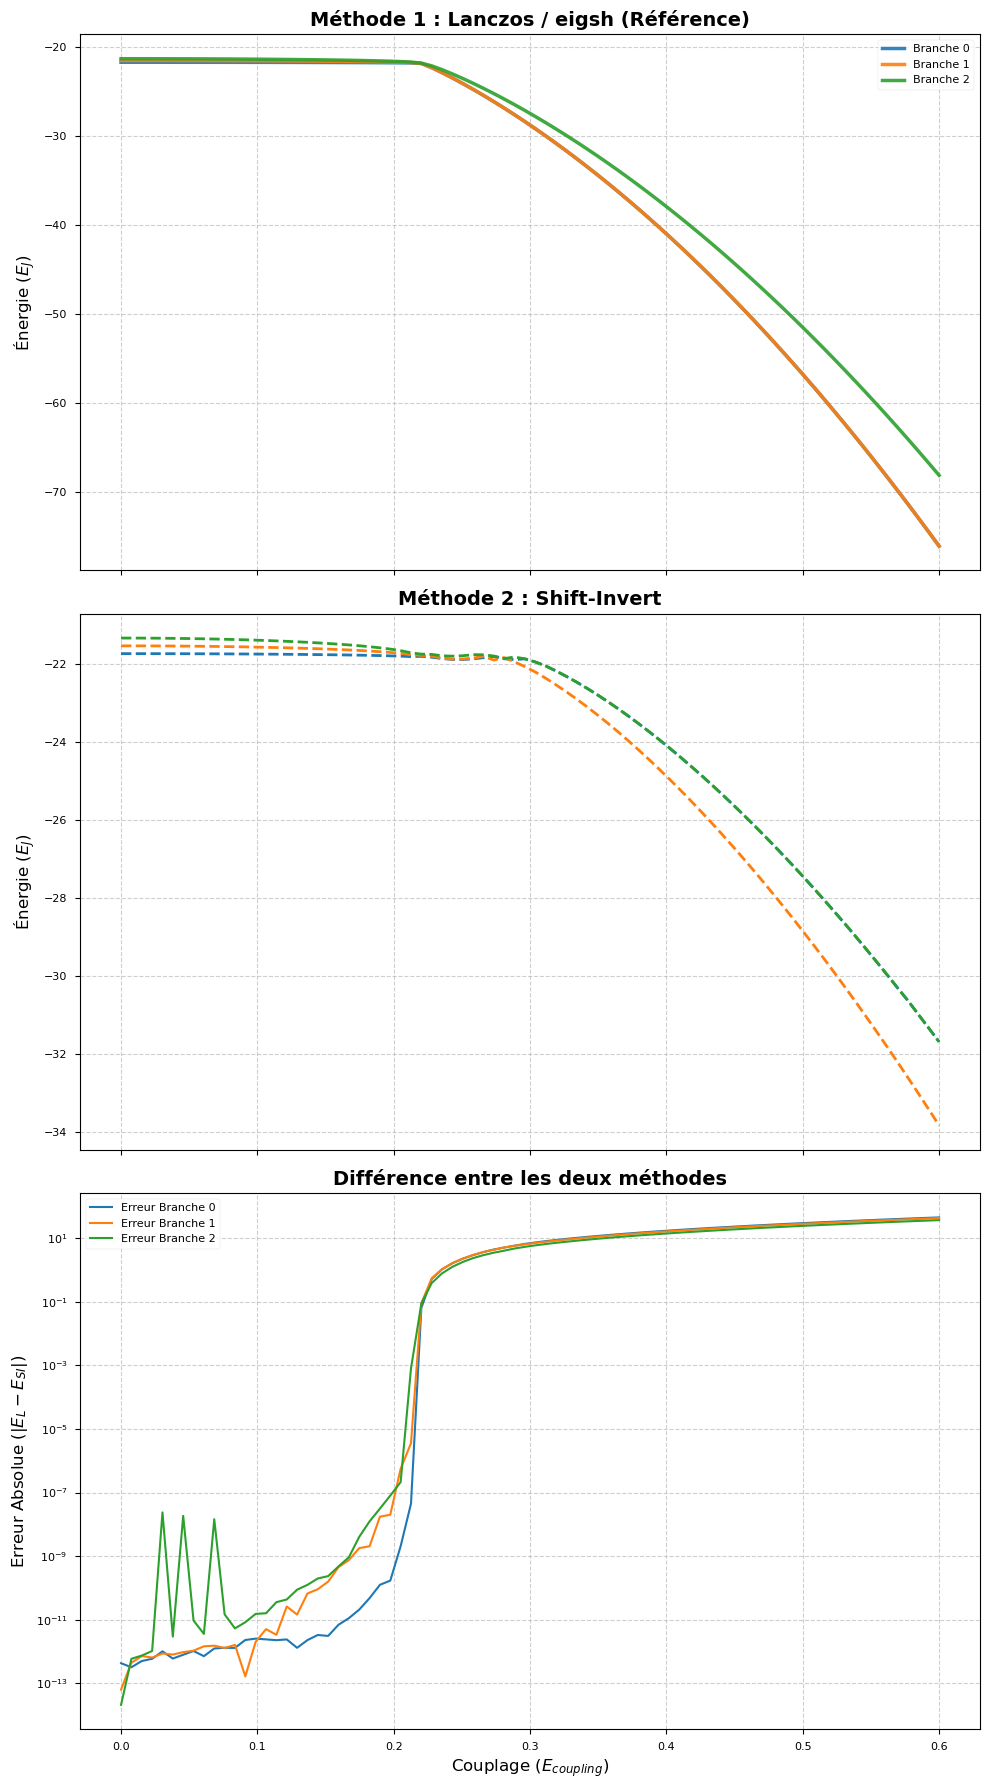

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Vérification des dimensions pour le plot
# Matplotlib aime avoir (n_steps, n_states) pour tracer les colonnes.
# Si tes données sont (3, 80), on transpose pour avoir (80, 3).
if energies_l_c.shape[0] != len(coupling_list):
    energies_l_c = energies_l_c.T
if energies_si_opt_c.shape[0] != len(coupling_list):
    energies_si_opt_c = energies_si_opt_c.T

# 2. Calcul de la différence (Erreur absolue)
diff = np.abs(energies_l_c - energies_si_opt_c)

# 3. Création des 3 graphiques
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# --- Plot 1 : Lanczos (Référence) ---
axs[0].plot(coupling_list, energies_l_c, linewidth=2.5, alpha=0.9)
axs[0].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[0].set_title("Méthode 1 : Lanczos / eigsh (Référence)", fontsize=14, fontweight="bold")
axs[0].grid(True, which="both", linestyle="--", alpha=0.6)
axs[0].legend([f"Branche {i}" for i in range(energies_l_c.shape[1])], loc="upper right")

# --- Plot 2 : Shift-Invert (Ton Algo) ---
# J'utilise des tirets (--) pour bien distinguer visuellement du trait plein
axs[1].plot(coupling_list, energies_si_opt_c, linewidth=2, linestyle="--")
axs[1].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[1].set_title("Méthode 2 : Shift-Invert", fontsize=14, fontweight="bold")
axs[1].grid(True, which="both", linestyle="--", alpha=0.6)

# --- Plot 3 : Différence (Échelle Logarithmique) ---
# C'est ici qu'on juge la qualité de la convergence
for i in range(diff.shape[1]):
    axs[2].semilogy(coupling_list, diff[:, i], label=f"Erreur Branche {i}", linewidth=1.5)

axs[2].set_ylabel("Erreur Absolue ($|E_L - E_{SI}|$)", fontsize=12)
axs[2].set_xlabel("Couplage ($E_{coupling}$)", fontsize=12)
axs[2].set_title("Différence entre les deux méthodes", fontsize=14, fontweight="bold")
axs[2].grid(True, which="both", linestyle="--", alpha=0.6)
axs[2].legend()

# Mise en page
plt.tight_layout()
plt.show()